# 使用xgboost进行预测

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import os

In [6]:
# 股票列表
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',]  # 科技
tickers += ['JPM', 'BAC', 'C', 'WFC', 'GS',]            # 金融
tickers += ['JNJ', 'PFE', 'MRK', 'ABBV', 'BMY',]         # 医药
tickers += ['XOM', 'CVX', 'COP', 'SLB', 'BKR',]          # 能源
tickers += ['DIS', 'NFLX', 'CMCSA', 'NKE', 'SBUX',]      # 消费
tickers += ['CAT', 'DE', 'MMM', 'GE', 'HON']            # 工业

# 参数
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [25, 50, 100, 200]
}

num_features_to_keep = 9

In [7]:
def get_stock_data(ticker):
    data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
    # 日期
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Day'] = data.index.day

    close = data['Close'].shift(1)
    # 移动平均线
    data['MA5'] = close.rolling(window=5).mean()
    data['MA10'] = close.rolling(window=10).mean()
    data['MA20'] = close.rolling(window=20).mean()

    # RSI
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    data.loc[data.index >= RSI.index[0], 'RSI'] = RSI

    # MACD
    exp1 = close.ewm(span=12, adjust=False).mean()
    exp2 = close.ewm(span=26, adjust=False).mean()
    MACD = exp1 - exp2
    data.loc[data.index >= MACD.index[0], 'MACD'] = MACD

    # VWAP
    data['VWAP'] = (close * data['Volume']).cumsum() / data['Volume'].cumsum()
    
    # Bollinger Bands
    period = 20
    data['SMA'] = close.rolling(window=period).mean()
    data['Std_dev'] = close.rolling(window=period).std()
    data['Upper_band'] = data['SMA'] + 2 * data['Std_dev']
    data['Lower_band'] = data['SMA'] - 2 * data['Std_dev']

    # 相对大盘的表现
    benchmark_data = yf.download('SPY', start='2020-01-01', end='2024-01-01')['Close'].shift(1)
    data['Relative_Performance'] = (close / benchmark_data.values) * 100

    # 价格变化率
    data['ROC'] = (close.pct_change(periods=1)) * 100

    # 平均变化率
    high_low_range = data['High'].shift(1) - data['Low'].shift(1)
    high_close_range = abs(data['High'].shift(1) - close.shift(1))
    low_close_range = abs(data['Low'].shift(1) - close.shift(1))
    true_range = pd.concat([high_low_range, high_close_range, low_close_range], axis=1).max(axis=1)
    data['ATR'] = true_range.rolling(window=14).mean()

    returns = close.pct_change().dropna()
    risk_free_rate = 0.01  # 假设无风险利率为1%
    excess_returns = returns - risk_free_rate / 252
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    data['Sharpe_Ratio'] = sharpe_ratio

    covariance = returns.cov(benchmark_data.pct_change().dropna())
    benchmark_variance = benchmark_data.pct_change().dropna().var()
    beta = covariance / benchmark_variance
    data['Beta'] = beta

    data['Open_yes'] = data['Open'].shift(1)
    data['Close_yes'] = data['Close'].shift(1)
    data['High_yes'] = data['High'].shift(1)
    data['Low_yes'] = data['Low'].shift(1)

    data = data.dropna()
    return data

# 获取所有股票数据
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}
stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

{'AAPL':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2020-01-31   80.232498   80.669998   77.072502   77.377502   75.185593   
 2020-02-03   76.074997   78.372498   75.555000   77.165001   74.979118   
 2020-02-04   78.827499   79.910004   78.407501   79.712502   77.454445   
 2020-02-05   80.879997   81.190002   79.737503   80.362503   78.086044   
 2020-02-06   80.642502   81.305000   80.065002   81.302498   78.999390   
 ...                ...         ...         ...         ...         ...   
 2023-12-22  195.179993  195.410004  192.970001  193.600006  193.091385   
 2023-12-26  193.610001  193.889999  192.830002  193.050003  192.542831   
 2023-12-27  192.490005  193.500000  191.089996  193.149994  192.642548   
 2023-12-28  194.139999  194.660004  193.169998  193.580002  193.071426   
 2023-12-29  193.899994  194.399994  191.729996  192.529999  192.024185   
 
               

In [8]:
def format_feature(data):
    features = ['Volume', 'Year', 'Month', 'Day', 'MA5', 'MA10', 'MA20', 'RSI', 'MACD', 'Open', 'Close', 'High', 'Low'\
                , 'VWAP', 'SMA', 'Std_dev', 'Upper_band', 'Lower_band', 'Relative_Performance', 'ATR']
    X = data[features]
    y = data['Close'].pct_change()
    # y = (data['Close'] - data['Open'])
    X = X.iloc[1:]
    y = y.iloc[1:]
    return X, y

# 格式化数据
stock_features = {ticker: format_feature(data) for ticker, data in stock_data.items()}
print("stock_features:", stock_features)

stock_features: {'AAPL': (               Volume  Year  Month  Day         MA5        MA10        MA20  \
Date                                                                          
2020-02-03  173788400  2020      2    3   79.218001   79.372501   78.123625   
2020-02-04  136616400  2020      2    4   79.203500   79.120751   78.264000   
2020-02-05  118826800  2020      2    5   79.261501   79.177751   78.502126   
2020-02-06  105425600  2020      2    6   79.117001   79.271501   78.790376   
2020-02-07  117684000  2020      2    7   79.184001   79.421001   79.065625   
...               ...   ...    ...  ...         ...         ...         ...   
2023-12-22   37122800  2023     12   22  195.982001  195.958002  193.487000   
2023-12-26   28919300  2023     12   26  195.188000  195.747002  193.668501   
2023-12-27   48087700  2023     12   27  194.620001  195.734003  193.831501   
2023-12-28   34049900  2023     12   28  193.862000  195.578001  193.969001   
2023-12-29   42628800  202

In [9]:
def feature_selection_for_stocks(stock_features, best_params, num_features_to_keep=8):
    feature_importances_all = {}
    stock_features_selected = {}

    # 训练模型，获得所有股票的特征重要度
    for ticker, (X, y) in stock_features.items():
        params = best_params

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **params)
        xgb_model.fit(X, y)
        feature_importances = xgb_model.feature_importances_

        feature_importance_list = [(feature, importance) for feature, importance in zip(X.columns, feature_importances)]
        feature_importance_list.sort(key=lambda x: x[1], reverse=True)
        
        feature_importances_all[ticker] = feature_importance_list

    # 打印每支股票的特征重要度排名
    for ticker, importance_list in feature_importances_all.items():
        # print(f"Stock: {ticker}")
        for feature, importance in importance_list:
            pass
            # print(f"Importance of {feature}: {importance:.2f}")
    # print(feature_importances_all)
    feature_importance_totals = {}
    # 平均值
    for stock, feature_importances in feature_importances_all.items():
        for feature, importance in feature_importances:
            if feature in feature_importance_totals:
                feature_importance_totals[feature] += importance
            else:
                feature_importance_totals[feature] = importance
    num_stocks = len(feature_importances_all)
    average_feature_importances = {feature: importance / num_stocks for feature, importance in feature_importance_totals.items()}
    # average_feature_importances = sorted(average_feature_importances, key=lambda x: x[1], reverse=True)
    for feature, avg_importance in average_feature_importances.items():
        print(f"Average importance of {feature} across all stocks: {avg_importance:.2f}")

    # 只保留重要的特征
    importance_list = sorted(average_feature_importances.items(), key=lambda x: x[1], reverse=True)
    importance_list = importance_list[:num_features_to_keep]
    important_features = [feature for feature, importance in importance_list[:num_features_to_keep]]
    print(f"Selected the top{num_features_to_keep} stocks: {important_features}")
    for stock in stock_features:
        # X_selected = stock_features[stock][0]
        stock_features_selected[stock] = stock_features[stock]
    return stock_features_selected

# 进行特征选择
temp_params = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 50, 'subsample': 0.6}
stock_features_selected = feature_selection_for_stocks(stock_features, temp_params, num_features_to_keep)

Average importance of Close across all stocks: 0.08
Average importance of Low across all stocks: 0.08
Average importance of Open across all stocks: 0.06
Average importance of SMA across all stocks: 0.06
Average importance of High across all stocks: 0.05
Average importance of MA5 across all stocks: 0.05
Average importance of Upper_band across all stocks: 0.06
Average importance of Lower_band across all stocks: 0.06
Average importance of Std_dev across all stocks: 0.05
Average importance of MA10 across all stocks: 0.05
Average importance of Relative_Performance across all stocks: 0.06
Average importance of VWAP across all stocks: 0.05
Average importance of ATR across all stocks: 0.05
Average importance of Volume across all stocks: 0.04
Average importance of RSI across all stocks: 0.04
Average importance of MACD across all stocks: 0.06
Average importance of MA20 across all stocks: 0.04
Average importance of Day across all stocks: 0.03
Average importance of Month across all stocks: 0.03
Av

In [10]:
def train_model(X, y):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
    tscv = TimeSeriesSplit(n_splits=2)
    best_score = None
    best_params = None

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        current_best_params = grid_search.best_params_

        model = xgb.XGBRegressor(objective='reg:squarederror', seed=2, **current_best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        if best_score is None or score < best_score:
            best_score = score
            best_params = current_best_params

    return best_params

# 调参并获取最优参数组合
best_params = {ticker: train_model(X, y) for ticker, (X, y) in stock_features_selected.items()}

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidates, totalling 1440 fits
Fitting 2 folds for each of 720 candidat

In [11]:
best_params

{'AAPL': {'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 50,
  'subsample': 0.8},
 'MSFT': {'colsample_bytree': 0.9,
  'learning_rate': 0.05,
  'max_depth': 12,
  'n_estimators': 25,
  'subsample': 0.6},
 'GOOGL': {'colsample_bytree': 0.7,
  'learning_rate': 0.001,
  'max_depth': 10,
  'n_estimators': 50,
  'subsample': 0.8},
 'AMZN': {'colsample_bytree': 0.9,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 100,
  'subsample': 0.6},
 'TSLA': {'colsample_bytree': 0.9,
  'learning_rate': 0.001,
  'max_depth': 12,
  'n_estimators': 100,
  'subsample': 1.0},
 'JPM': {'colsample_bytree': 0.9,
  'learning_rate': 0.01,
  'max_depth': 8,
  'n_estimators': 25,
  'subsample': 0.6},
 'BAC': {'colsample_bytree': 0.9,
  'learning_rate': 0.01,
  'max_depth': 8,
  'n_estimators': 50,
  'subsample': 1.0},
 'C': {'colsample_bytree': 0.9,
  'learning_rate': 0.01,
  'max_depth': 12,
  'n_estimators': 50,
  'subsample': 0.6},
 'WFC': {'colsample_bytree

Running prediction for the stock AAPL...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.185762              -0.910345  1.096107
1                  0.221688               0.696947 -0.475259
2                  0.379948               0.830559 -0.450611
3                  0.548331              -1.229330  1.777661
4                  0.508238              -0.398032  0.906270
..                      ...                    ...       ...
191               -2.119914              -0.554750 -1.565164
192               -2.798710              -0.284092 -2.514618
193               -0.954304               0.051795 -1.006100
194               -0.972447               0.222629 -1.195076
195               -0.770329              -0.542413 -0.227916

[196 rows x 3 columns]
Naive strategy earn rate: 20.317663806722816 %
Xgboost strategy earn rate: 28.713655669762687 %


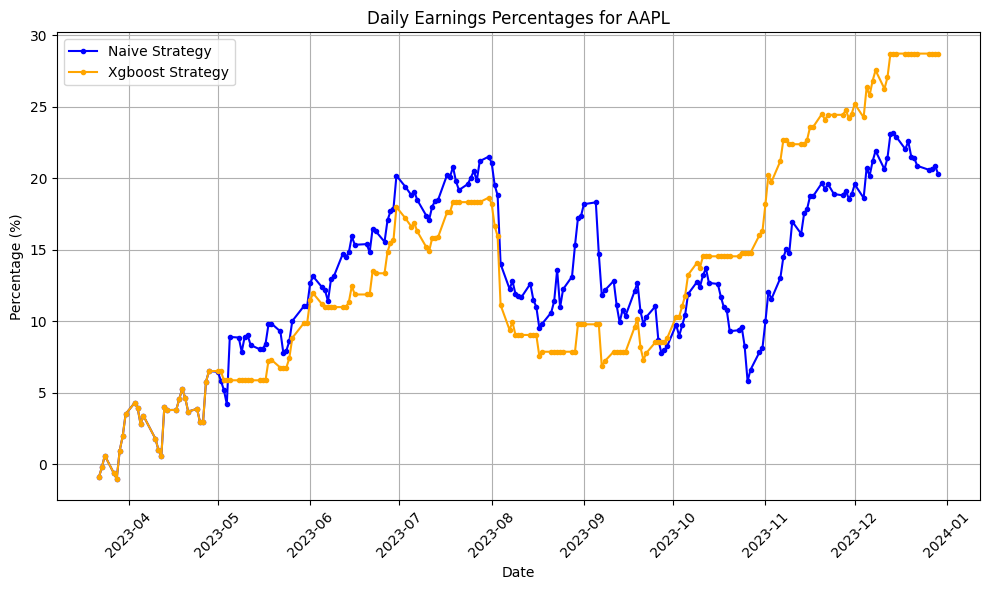

Running prediction for the stock MSFT...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.089448              -0.544229  0.633677
1                 -0.575009               1.972160 -2.547169
2                 -0.064456               1.048046 -1.112501
3                  0.740170              -1.493389  2.233559
4                  0.400521              -0.416092  0.816613
..                      ...                    ...       ...
191                1.213550               0.278411  0.935138
192                0.773647               0.021362  0.752285
193                0.551689              -0.157475  0.709164
194               -1.149964               0.323467 -1.473431
195               -0.694311               0.202518 -0.896829

[196 rows x 3 columns]
Naive strategy earn rate: 33.798491804600495 %
Xgboost strategy earn rate: 36.97154003938523 %


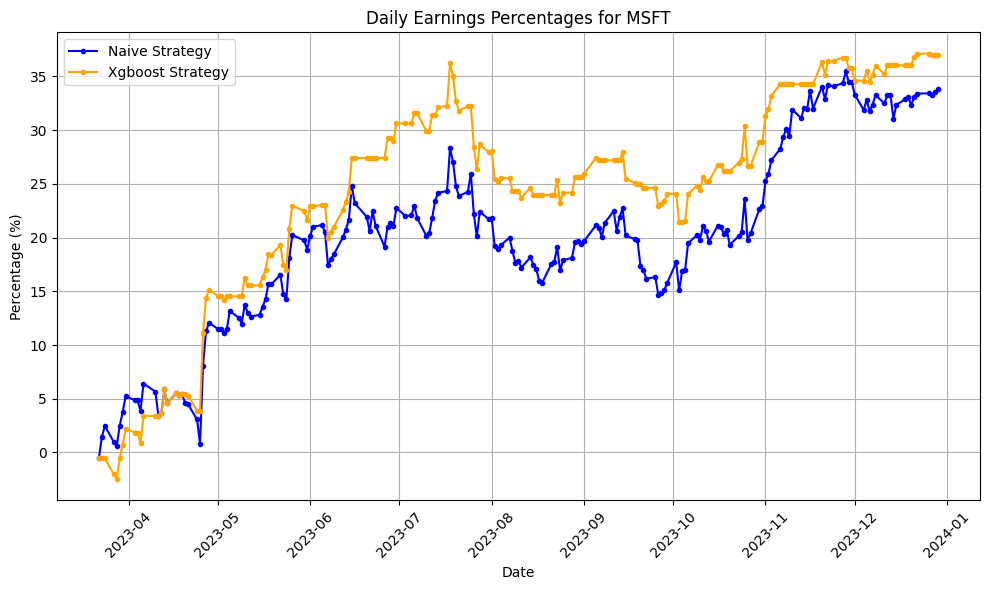

Running prediction for the stock GOOGL...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.090197              -1.477312  1.567509
1                  0.119351               2.157295 -2.037944
2                  0.166573              -0.151511  0.318084
3                 -0.012995              -2.826255  2.813260
4                 -0.114710              -1.395667  1.280957
..                      ...                    ...       ...
191                0.694568               0.762005 -0.067437
192               -0.102633               0.021202 -0.123835
193               -0.003675              -0.812612  0.808938
194               -0.291140              -0.099736 -0.191404
195               -0.079829              -0.385077  0.305248

[196 rows x 3 columns]
Naive strategy earn rate: 31.501049482686344 %
Xgboost strategy earn rate: 59.91687225392071 %


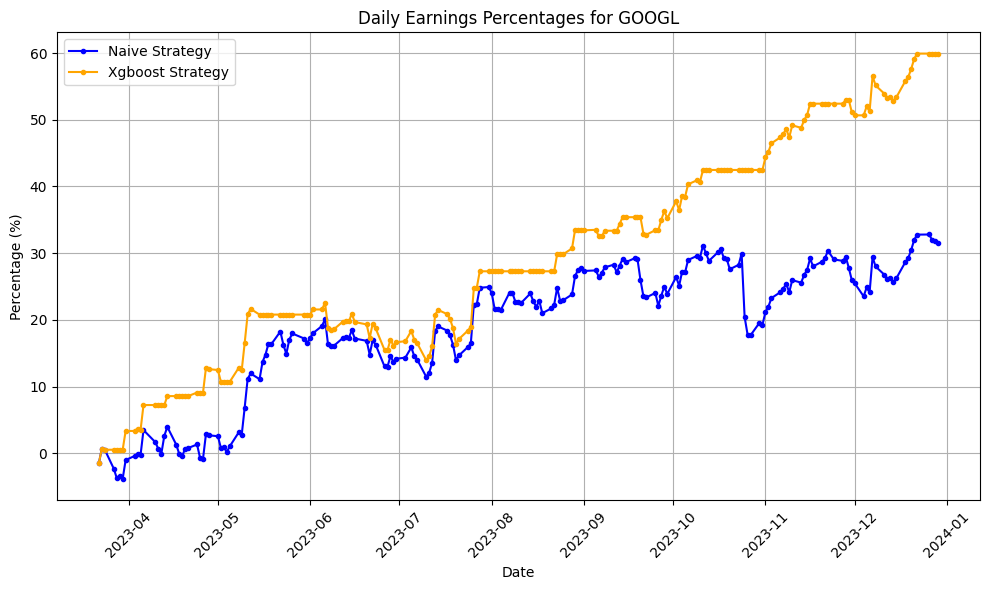

Running prediction for the stock AMZN...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.207401              -1.898423  2.105824
1                 -0.260647               0.010134 -0.270781
2                 -0.039527              -0.587582  0.548055
3                 -0.231687              -0.091711 -0.139976
4                  0.027727              -0.815997  0.843723
..                      ...                    ...       ...
191               -0.334071              -0.273010 -0.061061
192               -1.852305              -0.006514 -1.845790
193               -0.770691              -0.045634 -0.725057
194               -2.703474               0.026091 -2.729565
195               -0.346970              -0.938846  0.591877

[196 rows x 3 columns]
Naive strategy earn rate: 44.885604473421296 %
Xgboost strategy earn rate: 62.00846527756021 %


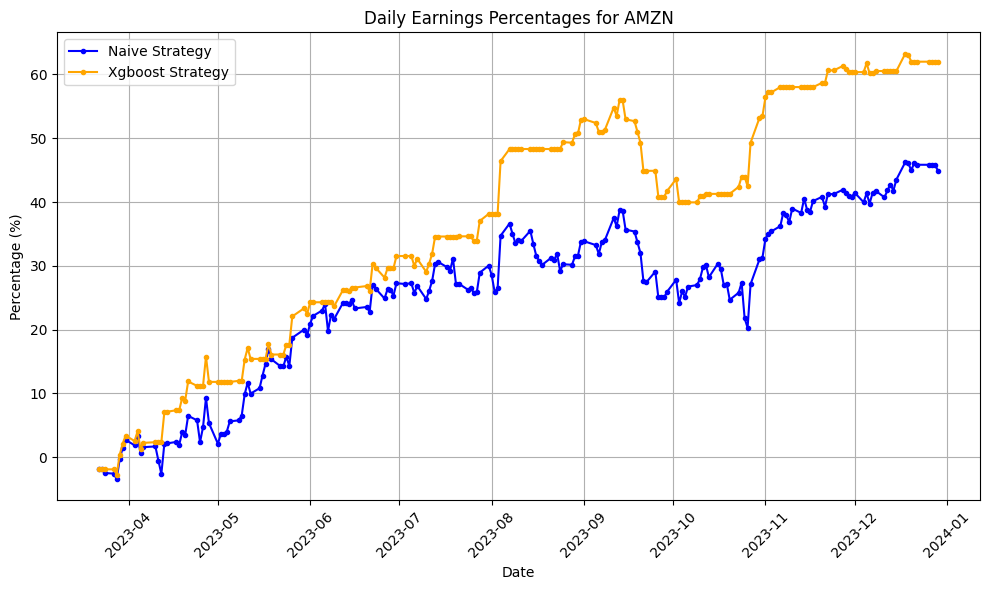

Running prediction for the stock TSLA...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.307944              -3.254382  3.562326
1                  0.034228               0.559774 -0.525545
2                  0.018329              -0.941628  0.959957
3                 -0.238080               0.735252 -0.973333
4                 -0.229467              -1.365933  1.136465
..                      ...                    ...       ...
191               -1.218353              -0.770140 -0.448213
192                0.222272               1.611623 -1.389351
193               -0.375846               1.882241 -2.258086
194               -0.229961              -3.159428  2.929468
195                2.060911              -1.856386  3.917297

[196 rows x 3 columns]
Naive strategy earn rate: 31.807376022475204 %
Xgboost strategy earn rate: 27.94710283221027 %


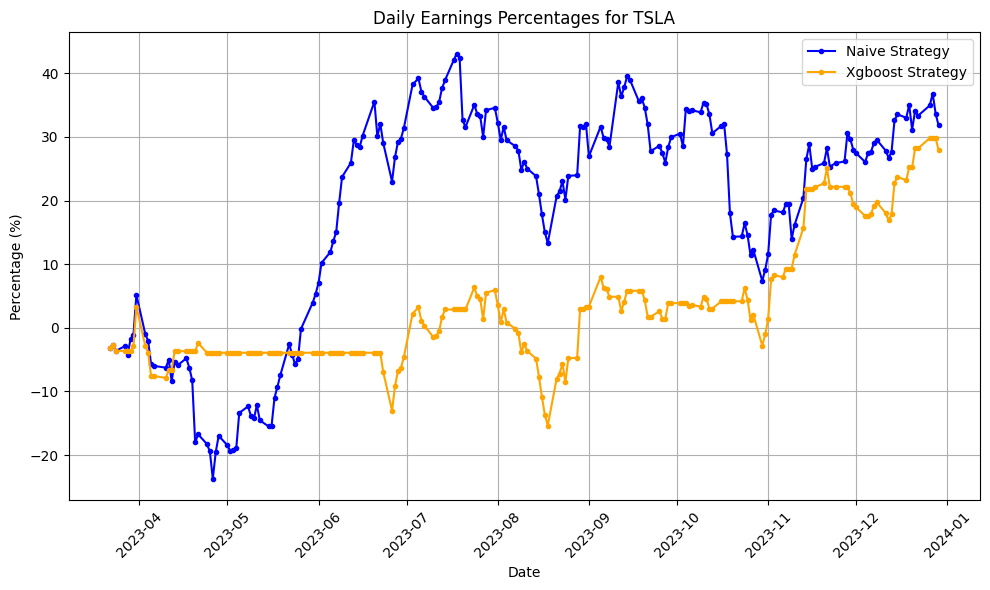

Running prediction for the stock JPM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.024503              -2.581388  2.605892
1                 -0.259296              -0.267341  0.008045
2                 -0.323240              -1.521596  1.198357
3                 -0.045243               2.866065 -2.911308
4                 -0.526301               0.303525 -0.829826
..                      ...                    ...       ...
191               -0.065910              -0.059705 -0.006205
192                0.606276               0.591401  0.014875
193                0.304476               0.599795 -0.295319
194                0.181285               0.531292 -0.350008
195                0.416810              -0.117438  0.534248

[196 rows x 3 columns]
Naive strategy earn rate: 27.810432870861195 %
Xgboost strategy earn rate: 26.072144664294015 %


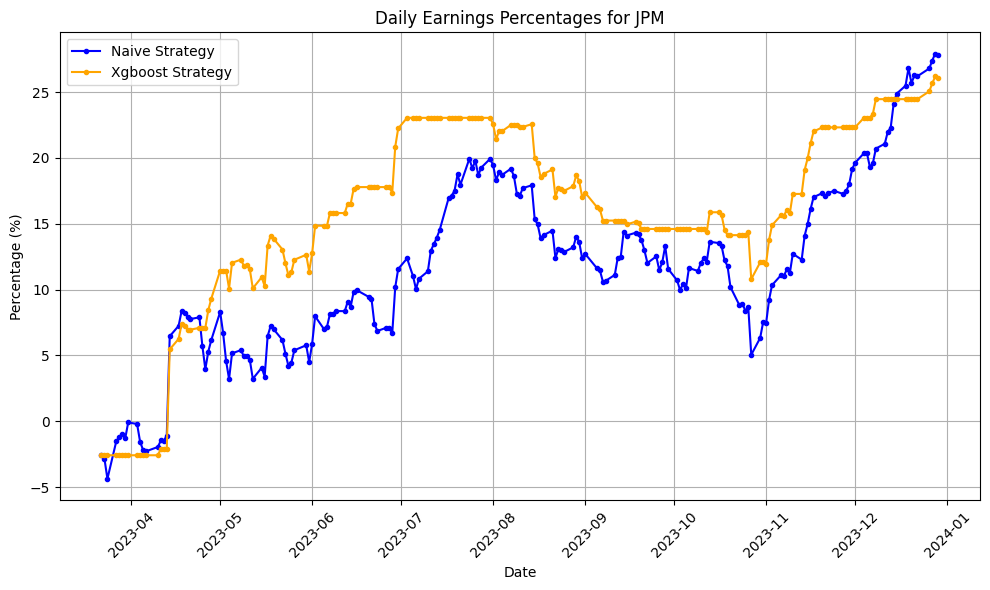

Running prediction for the stock BAC...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.708929              -3.322843  4.031772
1                  0.170832              -2.424023  2.594855
2                  1.312125               0.630330  0.681794
3                  1.114172               4.974209 -3.860037
4                 -1.740169              -1.298698 -0.441472
..                      ...                    ...       ...
191               -1.983543               0.692770 -2.676312
192                0.258277               1.286271 -1.027993
193               -1.658987              -0.059068 -1.599919
194               -0.082443               0.118206 -0.200649
195               -2.864647              -0.619843 -2.244804

[196 rows x 3 columns]
Naive strategy earn rate: 19.039324000143445 %
Xgboost strategy earn rate: 31.431545961749215 %


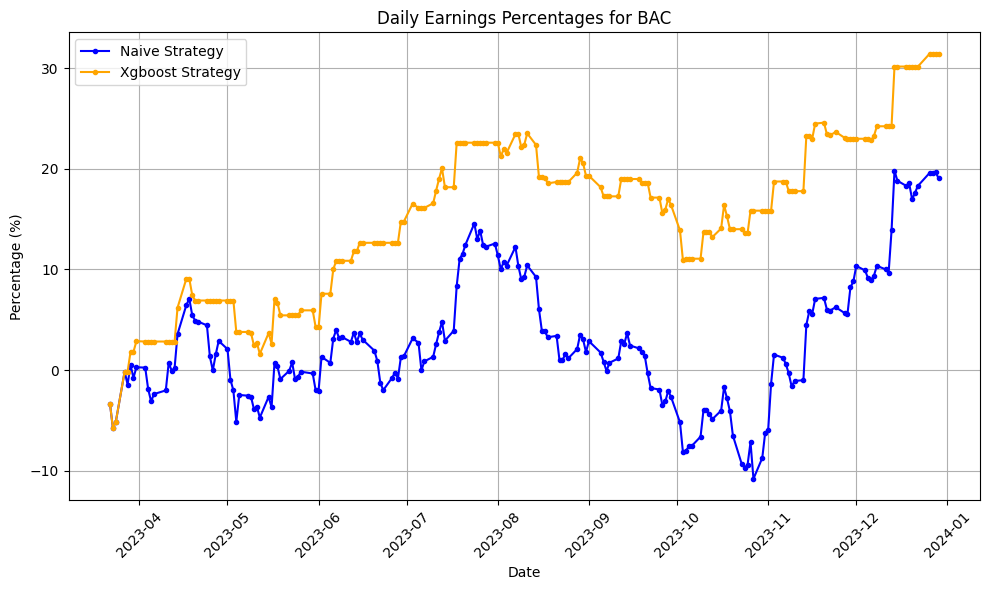

Running prediction for the stock C...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.136303              -3.017530  2.881226
1                 -0.290522              -0.594826  0.304303
2                 -0.420583              -0.782509  0.361926
3                 -0.143482               3.873807 -4.017289
4                  0.362261               0.982587 -0.620326
..                      ...                    ...       ...
191               -0.473686               0.513838 -0.987524
192                0.682114               0.943766 -0.261652
193                0.505455               0.233734  0.271721
194               -0.405134               0.116598 -0.521732
195                0.223690              -0.155283  0.378973

[196 rows x 3 columns]
Naive strategy earn rate: 15.240624339477904 %
Xgboost strategy earn rate: 41.94790751379647 %


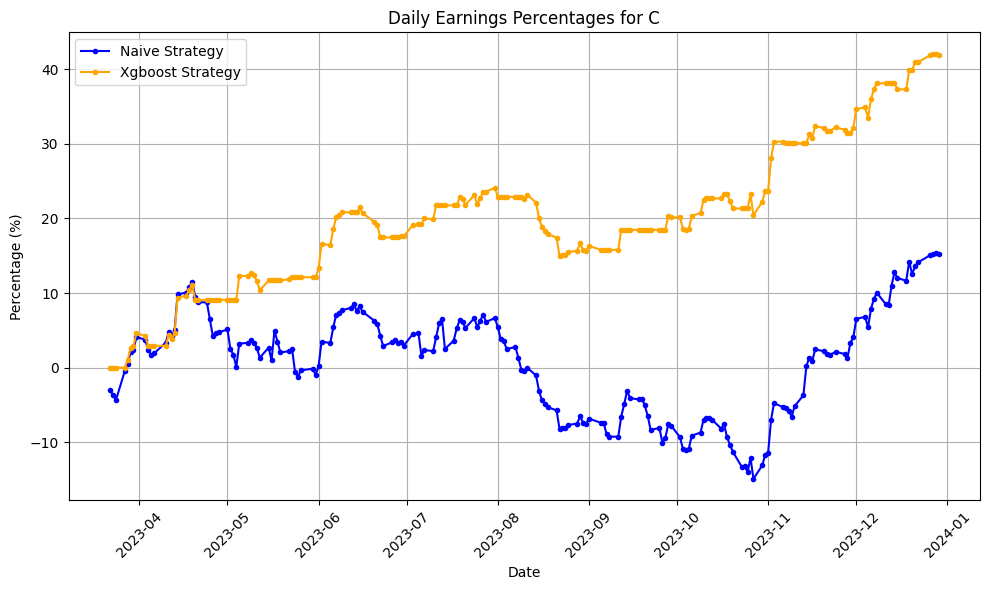

Running prediction for the stock WFC...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.875962              -3.326400  2.450438
1                 -2.121408              -1.586022 -0.535386
2                  1.605649              -1.037971  2.643619
3                 -2.995805               3.422583 -6.418387
4                  2.293023              -0.773955  3.066978
..                      ...                    ...       ...
191               -3.748161              -0.546007 -3.202154
192               -3.518370               0.935338 -4.453708
193                6.323709              -0.624491  6.948201
194               -2.451026               0.304070 -2.755095
195               -2.667305              -0.525461 -2.141843

[196 rows x 3 columns]
Naive strategy earn rate: 27.201725761267557 %
Xgboost strategy earn rate: 36.643110001704684 %


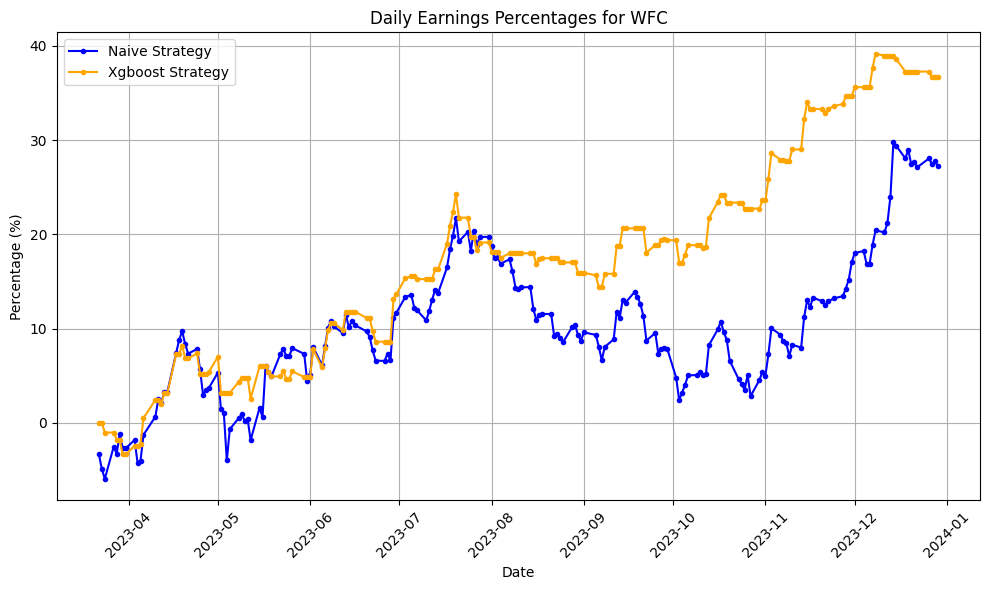

Running prediction for the stock GS...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.213663              -1.137792  1.351455
1                  0.204765               0.376189 -0.171424
2                  0.162307              -0.724154  0.886461
3                  0.370520               1.906770 -1.536250
4                  0.333655              -0.028254  0.361908
..                      ...                    ...       ...
191               -0.455815               0.021018 -0.476833
192               -0.167344               0.252198 -0.419542
193               -0.210372               0.752083 -0.962456
194                0.035786               0.501975 -0.466189
195                0.200462              -0.165631  0.366093

[196 rows x 3 columns]
Naive strategy earn rate: 21.43294770088386 %
Xgboost strategy earn rate: 37.97483248197422 %


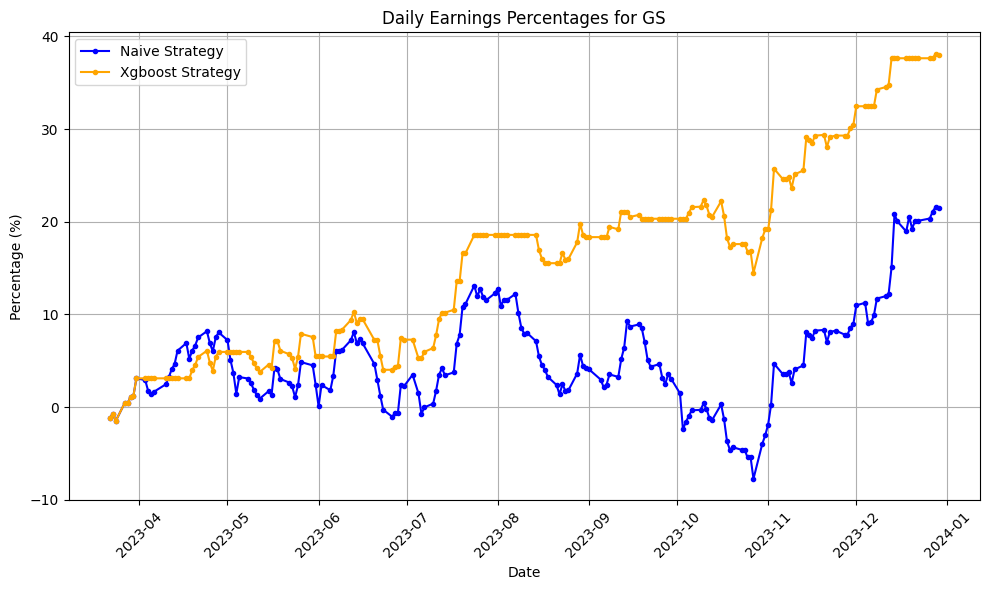

Running prediction for the stock JNJ...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.082578              -1.845472  1.762893
1                 -0.185397               0.052964 -0.238361
2                 -0.008914               1.005749 -1.014664
3                 -0.353698               0.425817 -0.779515
4                 -0.176368              -0.965424  0.789057
..                      ...                    ...       ...
191               -0.416948               0.400420 -0.817368
192               -0.256034               0.437407 -0.693440
193                1.013923               0.134499  0.879424
194                0.771929               0.147103  0.624826
195                0.998969               0.102187  0.896782

[196 rows x 3 columns]
Naive strategy earn rate: 2.9043705909312587 %
Xgboost strategy earn rate: 20.062255786246972 %


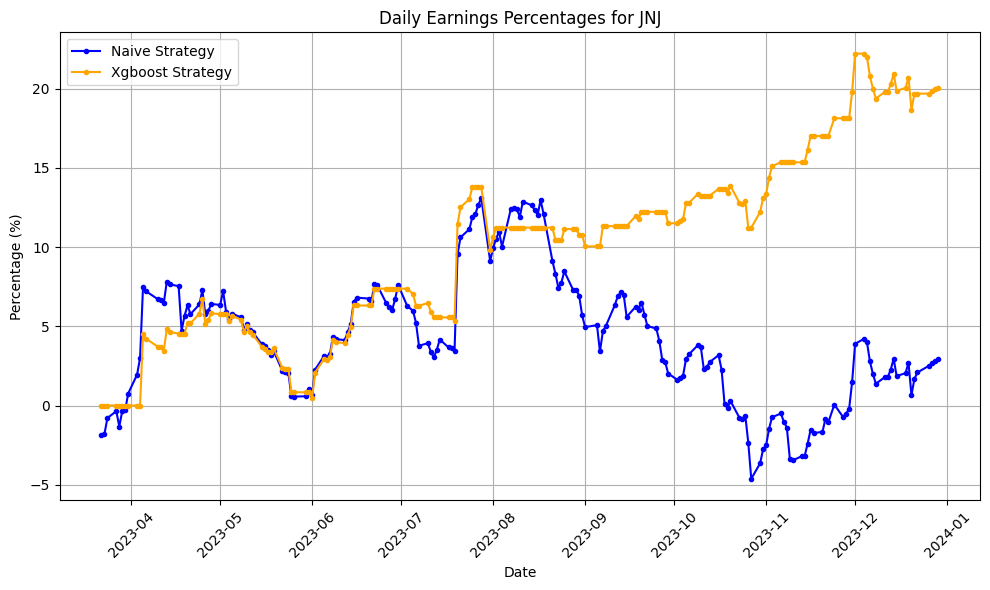

Running prediction for the stock PFE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.002952              -1.598626  1.601579
1                 -0.022370               0.424899 -0.447268
2                  0.012023               0.522646 -0.510623
3                 -0.369759              -0.420892  0.051133
4                 -0.115922              -0.571854  0.455932
..                      ...                    ...       ...
191               -0.987893               0.317909 -1.305802
192               -0.715114               0.035212 -0.750326
193               -0.612815               0.703980 -1.316796
194                0.231035               0.629152 -0.398117
195                0.218515               0.000000  0.218515

[196 rows x 3 columns]
Naive strategy earn rate: -32.26779980845476 %
Xgboost strategy earn rate: 20.210812237880496 %


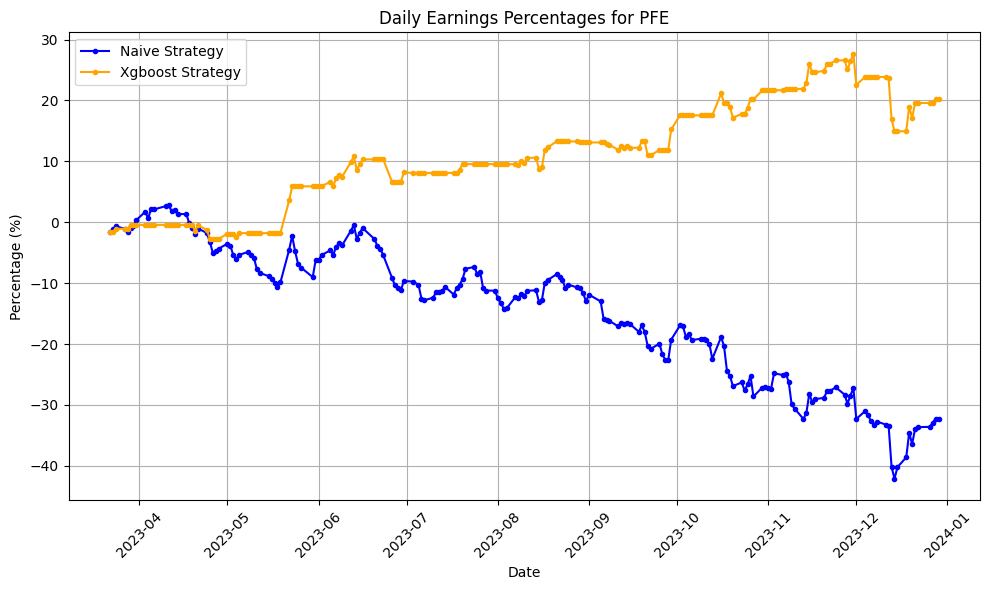

Running prediction for the stock MRK...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.278610              -1.080159  1.358768
1                 -0.573172              -0.162833 -0.410338
2                 -0.200955               0.546867 -0.747822
3                  1.621805               2.032440 -0.410635
4                  0.316486              -1.309269  1.625755
..                      ...                    ...       ...
191                0.190174               1.231316 -1.041142
192               -0.037265              -0.064995  0.027730
193               -1.957381               0.325194 -2.282575
194               -1.368132               0.731611 -2.099743
195               -3.833536               0.229843 -4.063379

[196 rows x 3 columns]
Naive strategy earn rate: 4.413436224771103 %
Xgboost strategy earn rate: 31.33350669340897 %


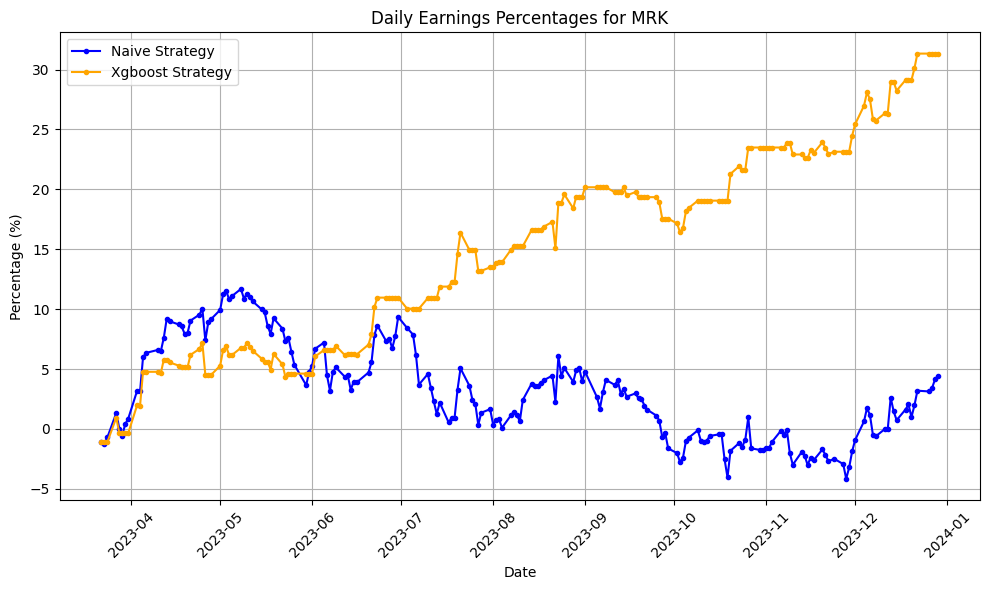

Running prediction for the stock ABBV...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.113891              -1.977423  2.091314
1                 -0.074915               1.060718 -1.135633
2                 -0.274291               1.751450 -2.025741
3                 -0.277481              -0.303766  0.026285
4                 -0.293779               0.450683 -0.744462
..                      ...                    ...       ...
191                0.813851               1.540079 -0.726228
192                0.489416              -0.206536  0.695953
193                0.525144               0.168161  0.356984
194               -0.034495              -0.083939  0.049444
195                0.596108               0.142166  0.453942

[196 rows x 3 columns]
Naive strategy earn rate: 0.36942016653265863 %
Xgboost strategy earn rate: 24.947465895134112 %


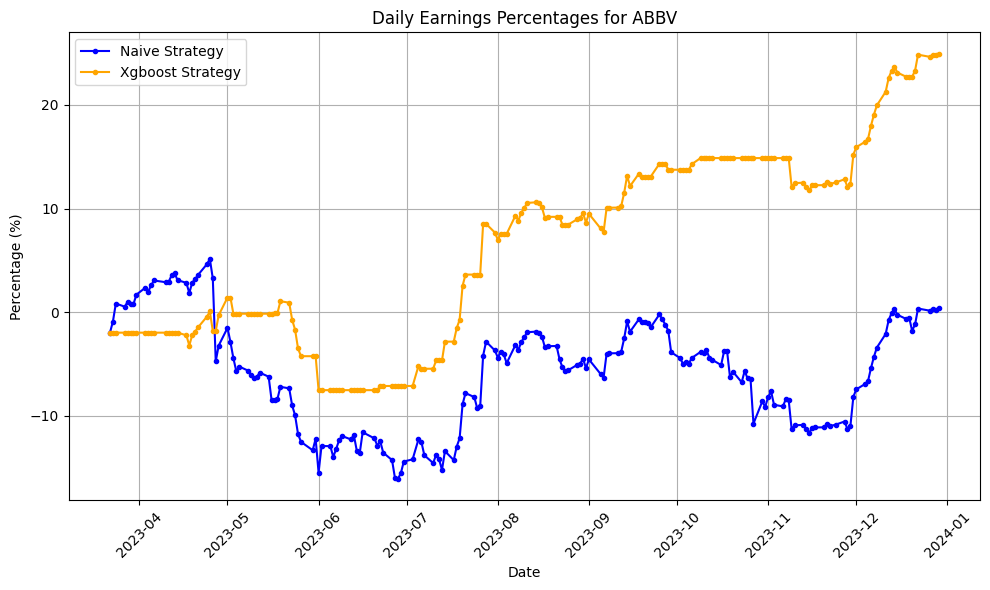

Running prediction for the stock BMY...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.263283              -0.399947  0.663230
1                 -0.477708              -0.386666 -0.091041
2                  0.076230               1.045083 -0.968853
3                  0.855967               0.576240  0.279727
4                  0.778209               0.190976  0.587233
..                      ...                    ...       ...
191                2.821779               2.009369  0.812410
192                0.792987              -1.606426  2.399413
193               -3.824740              -0.466476 -3.358264
194               -2.482329               0.019532 -2.501860
195                1.701493               0.175713  1.525780

[196 rows x 3 columns]
Naive strategy earn rate: -25.919987689596685 %
Xgboost strategy earn rate: 15.920710727216768 %


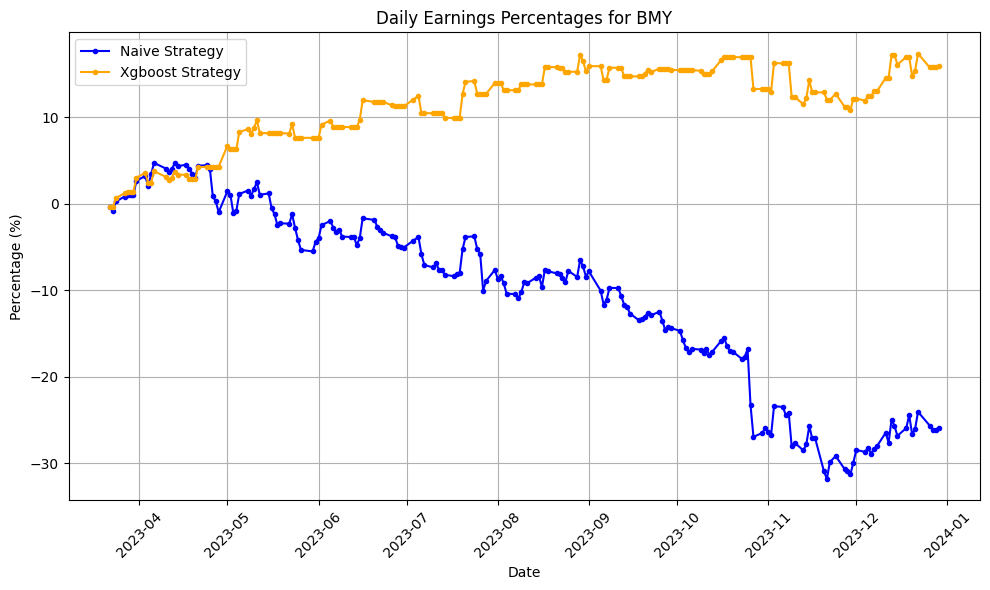

Running prediction for the stock XOM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.677466              -2.288868  2.966334
1                 -0.796796              -1.128208  0.331412
2                 -0.457061               0.116038 -0.573100
3                 -0.277864               2.192605 -2.470469
4                  2.719038               1.247637  1.471402
..                      ...                    ...       ...
191               -2.739955               0.176939 -2.916894
192               -0.721133               0.225685 -0.946818
193                0.067538              -0.469939  0.537477
194               -1.398974              -1.445998  0.047024
195                1.865466              -0.209601  2.075067

[196 rows x 3 columns]
Naive strategy earn rate: -4.637008059301722 %
Xgboost strategy earn rate: 38.416184120676824 %


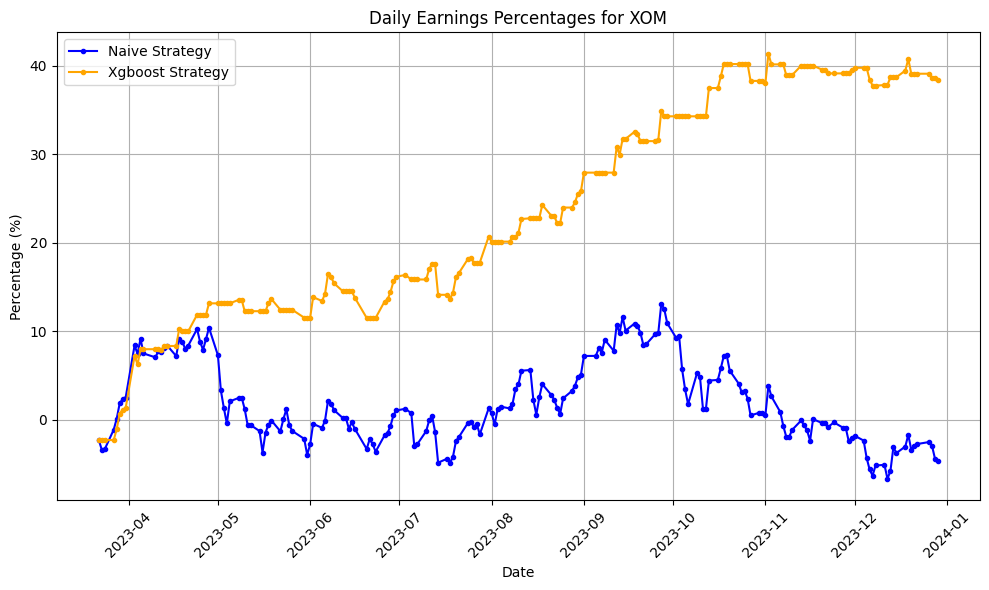

Running prediction for the stock CVX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.079503              -2.033765  2.113268
1                  0.044837              -0.993146  1.037983
2                  0.197592               0.996630 -0.799039
3                  0.222569               1.018837 -0.796267
4                  0.012819               1.167150 -1.154331
..                      ...                    ...       ...
191               -1.588825               0.225596 -1.814422
192               -1.848159               0.900365 -2.748523
193               -2.051092              -0.328062 -1.723029
194               -1.070697              -1.408728  0.338032
195                0.266539              -0.407292  0.673830

[196 rows x 3 columns]
Naive strategy earn rate: -4.681415199633271 %
Xgboost strategy earn rate: 26.320766459427514 %


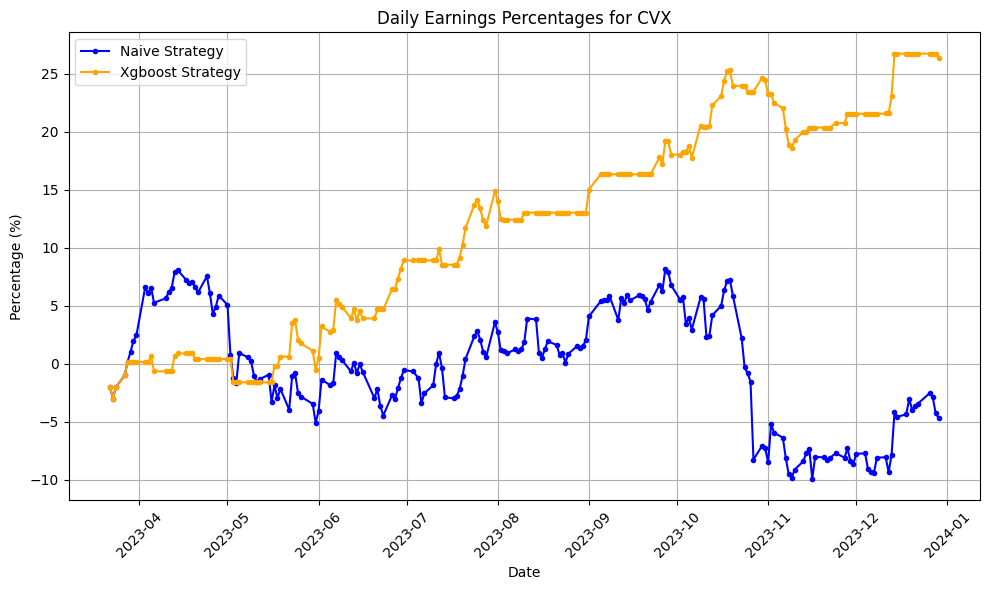

Running prediction for the stock COP...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  1.248807              -1.343894  2.592701
1                  0.778644              -1.982316  2.760960
2                 -0.268404              -1.026756  0.758352
3                 -1.609837               2.148175 -3.758011
4                  0.716986               0.461630  0.255356
..                      ...                    ...       ...
191               -1.340764               0.710436 -2.051200
192                0.523723               1.155867 -0.632143
193               -0.074048              -0.445302  0.371254
194               -0.907765              -1.679465  0.771700
195               -1.038271              -0.369099 -0.669172

[196 rows x 3 columns]
Naive strategy earn rate: 17.79238020038104 %
Xgboost strategy earn rate: 41.98075347474781 %


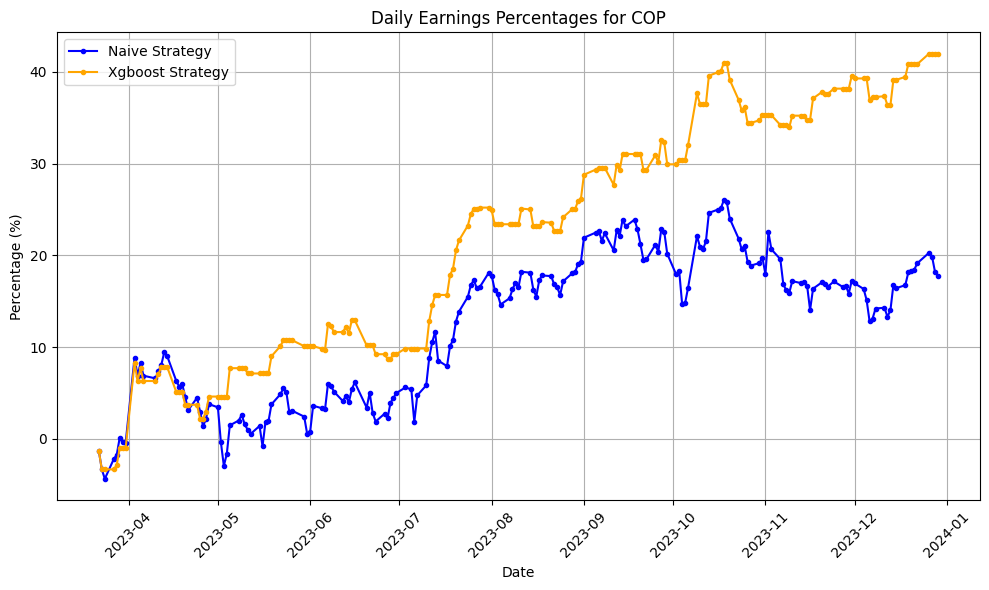

Running prediction for the stock SLB...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.123337              -1.822695  1.699358
1                 -0.525652              -4.050637  3.524985
2                 -1.281392              -2.000879  0.719487
3                  2.536762               4.936057 -2.399296
4                  1.521063               1.860164 -0.339102
..                      ...                    ...       ...
191                2.638905               0.950932  1.687973
192               -1.430046               1.130366 -2.560412
193               -2.742931              -1.210882 -1.532049
194               -3.853465              -1.489717 -2.363748
195               -0.908039              -0.382850 -0.525189

[196 rows x 3 columns]
Naive strategy earn rate: 11.368110128273162 %
Xgboost strategy earn rate: 25.961693901904447 %


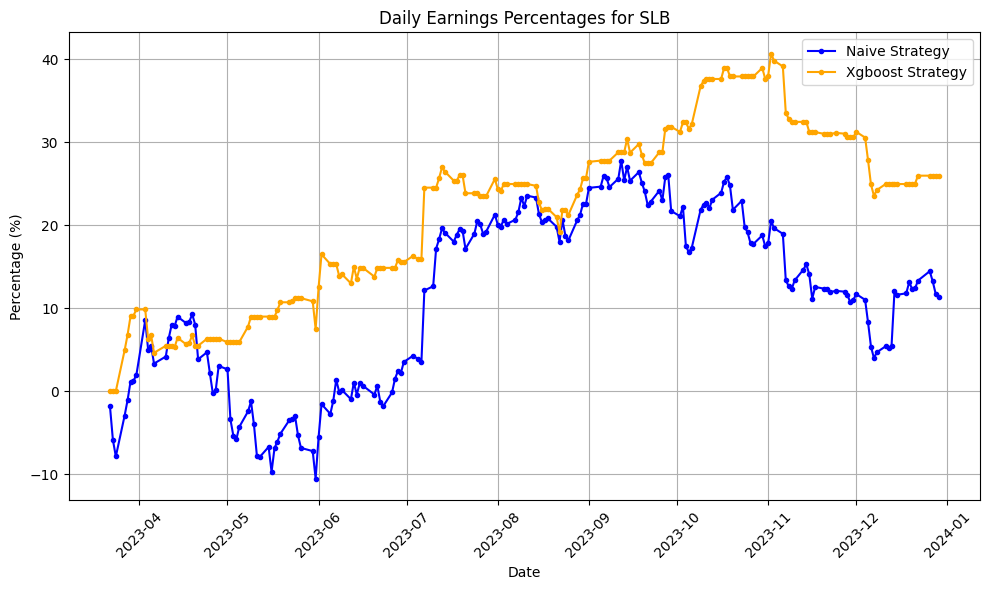

Running prediction for the stock BKR...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.168079              -3.566334  3.734413
1                  0.148455              -1.146455  1.294910
2                  0.639395               1.084927 -0.445532
3                  0.968871               0.888230  0.080641
4                  2.082723               1.173880  0.908843
..                      ...                    ...       ...
191               -0.335459               0.235012 -0.570471
192                0.380115               1.934349 -1.554234
193                0.289321              -0.833804  1.123125
194               -0.129872              -0.840826  0.710955
195               -1.388055              -0.058481 -1.329574

[196 rows x 3 columns]
Naive strategy earn rate: 22.20155858720932 %
Xgboost strategy earn rate: 41.54380505004512 %


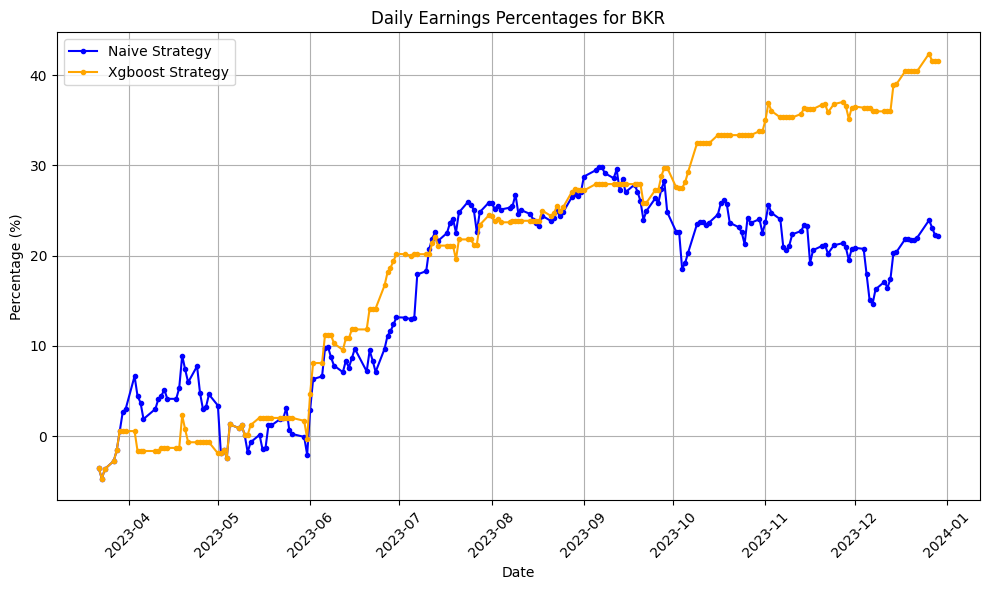

Running prediction for the stock DIS...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.056897              -1.698777  1.755674
1                  0.055430               0.979979 -0.924550
2                  0.098067              -1.826150  1.924217
3                  0.454567               1.636906 -1.182339
4                  0.254215              -0.836648  1.090864
..                      ...                    ...       ...
191               -1.718046              -1.086720 -0.631326
192               -0.489410              -0.076906 -0.412504
193                0.563744              -0.626718  1.190462
194                0.777410               0.022134  0.755276
195                0.872664              -0.121682  0.994346

[196 rows x 3 columns]
Naive strategy earn rate: -4.024834789000205 %
Xgboost strategy earn rate: 45.49757612150251 %


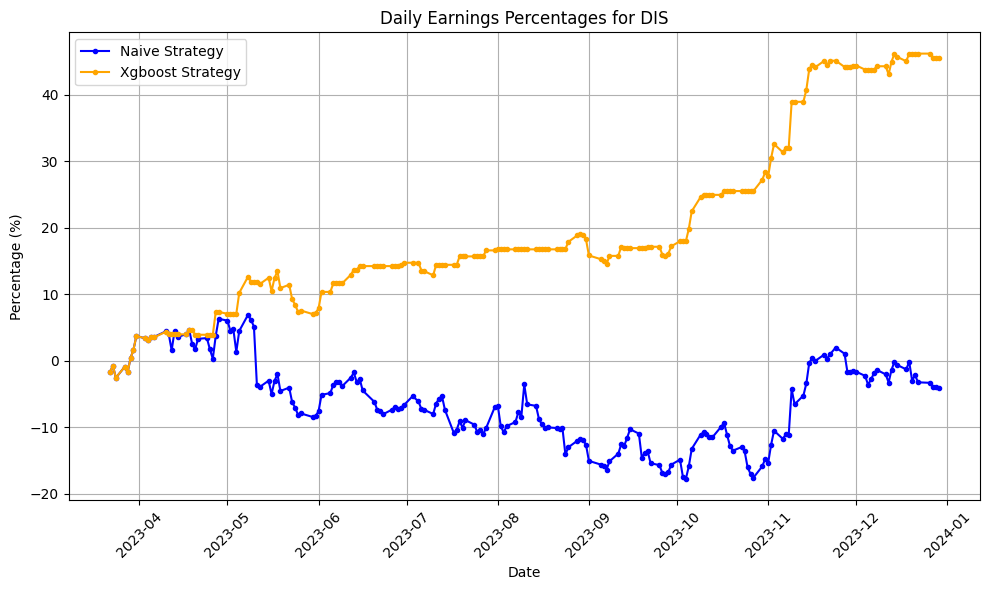

Running prediction for the stock NFLX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.026769              -3.888294  3.915063
1                  0.193199               9.006465 -8.813267
2                 -0.259725               2.503362 -2.763087
3                  0.196626              -0.222300  0.418926
4                 -0.276455              -1.263509  0.987054
..                      ...                    ...       ...
191                0.384387              -0.986549  1.370936
192               -0.047931               0.910098 -0.958029
193                0.054170               0.122154 -0.067984
194               -0.286525              -0.260273 -0.026252
195                0.200952              -0.740047  0.940999

[196 rows x 3 columns]
Naive strategy earn rate: 51.91211040341922 %
Xgboost strategy earn rate: 54.778370664906745 %


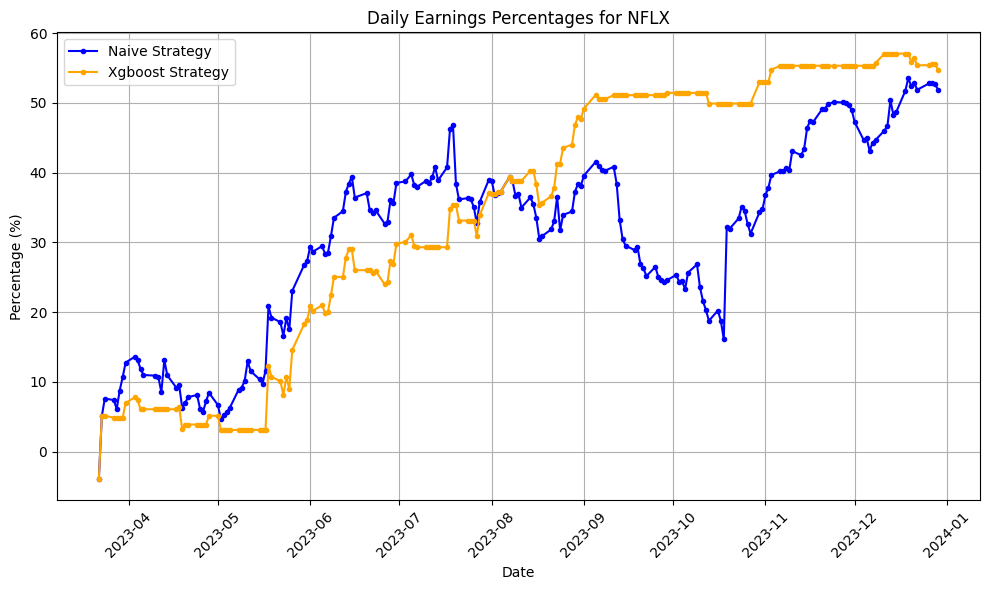

Running prediction for the stock CMCSA...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.266126              -2.135715  2.401841
1                 -0.572533              -0.635358  0.062825
2                 -0.234645              -0.139013 -0.095632
3                  0.098005               1.336312 -1.238307
4                 -0.361905               0.137361 -0.499266
..                      ...                    ...       ...
191                3.347530              -0.045435  3.392965
192                1.976732              -0.159090  2.135823
193               -1.087862               0.136584 -1.224446
194                0.001139               0.295515 -0.294376
195                1.884111              -0.611968  2.496080

[196 rows x 3 columns]
Naive strategy earn rate: 19.233763677315306 %
Xgboost strategy earn rate: 35.774446392488876 %


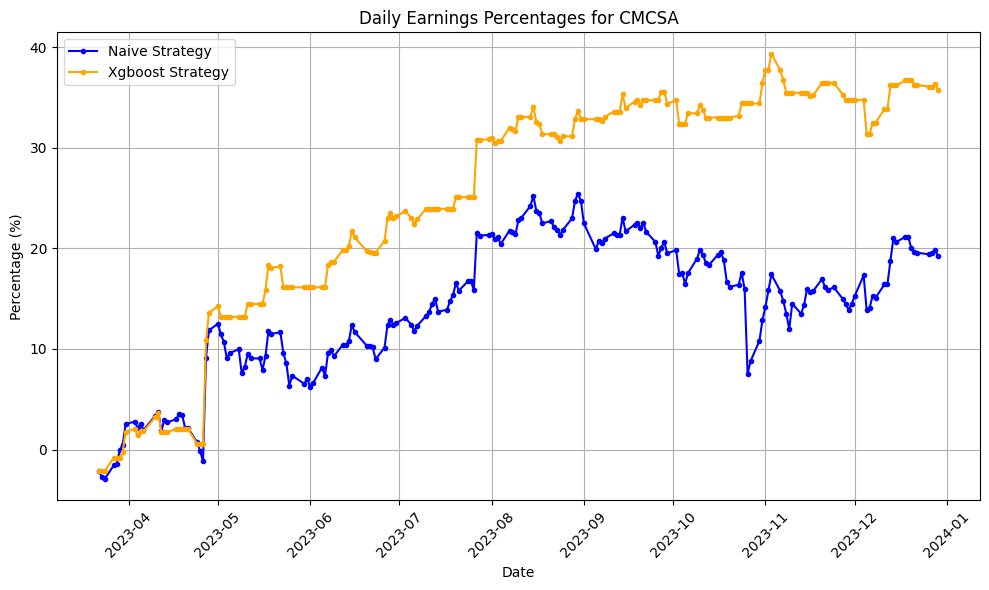

Running prediction for the stock NKE...
     predict_percentages(%)  actual_percentages(%)   delta(%)
0                 -0.074527              -4.864263   4.789735
1                 -0.096450               1.230127  -1.326577
2                  0.209245              -0.214931   0.424176
3                  0.114429              -2.402453   2.516882
4                  0.020026               0.050934  -0.030908
..                      ...                    ...        ...
191               -1.790671             -11.825674  10.035002
192                2.042675              -0.018516   2.061190
193                2.873684              -0.823921   3.697605
194                4.248282               1.577525   2.670757
195                4.267589              -0.229737   4.497326

[196 rows x 3 columns]
Naive strategy earn rate: -11.429971571108851 %
Xgboost strategy earn rate: 49.053120654260866 %


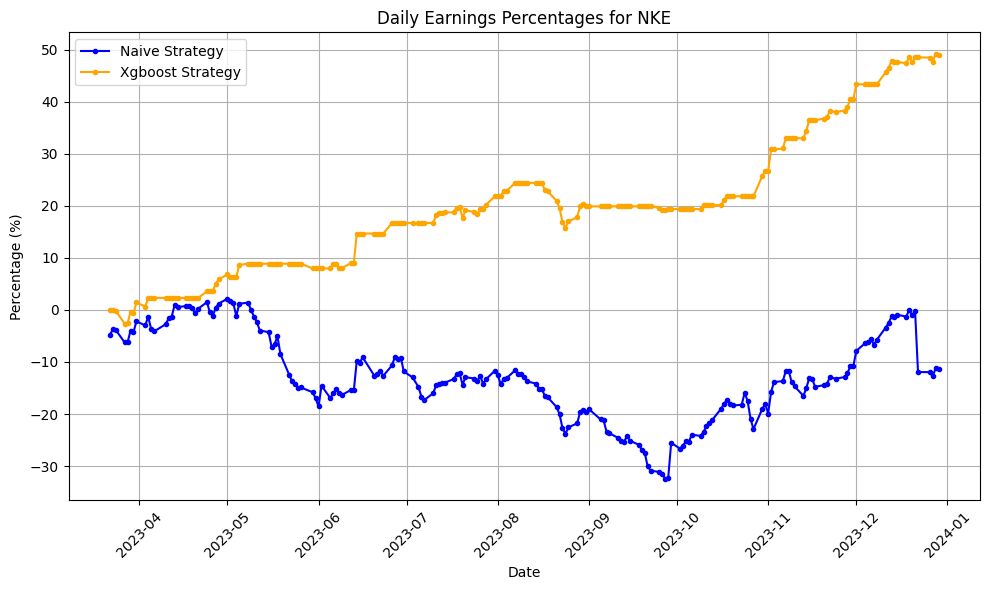

Running prediction for the stock SBUX...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.118971              -1.412371  1.531343
1                 -0.106701              -0.706219  0.599518
2                 -0.089662              -0.081286 -0.008376
3                 -0.046012               0.325409 -0.371422
4                  0.086170               0.060812  0.025357
..                      ...                    ...       ...
191               -0.937210              -0.052453 -0.884758
192               -0.122591               0.409319 -0.531910
193               -0.298216              -0.397196  0.098980
194                1.540039               0.671633  0.868405
195                0.760251               0.083396  0.676855

[196 rows x 3 columns]
Naive strategy earn rate: -2.555378811596018 %
Xgboost strategy earn rate: 34.48008276559678 %


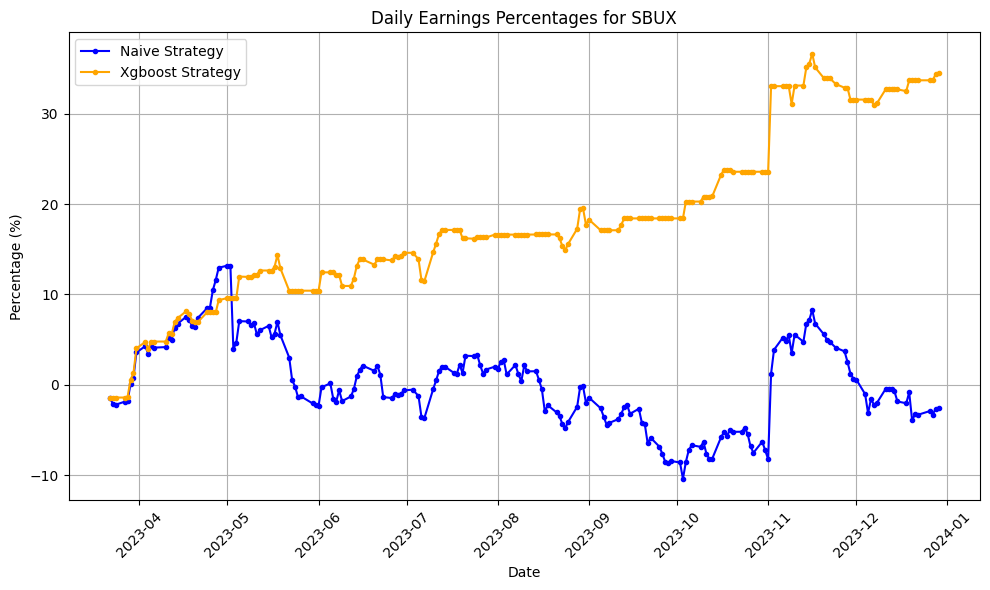

Running prediction for the stock CAT...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.357969              -2.209675  2.567645
1                  0.466356              -0.231868  0.698225
2                  0.189876              -1.107368  1.297244
3                  0.266094               0.456203 -0.190109
4                  0.361325               0.990827 -0.629502
..                      ...                    ...       ...
191               -1.327781               0.099968 -1.427749
192               -0.090680               1.814995 -1.905676
193               -0.502768               0.842266 -1.345034
194               -0.053827              -0.415937  0.362110
195               -0.405793              -0.407569  0.001777

[196 rows x 3 columns]
Naive strategy earn rate: 30.457369858408992 %
Xgboost strategy earn rate: 47.383774074308995 %


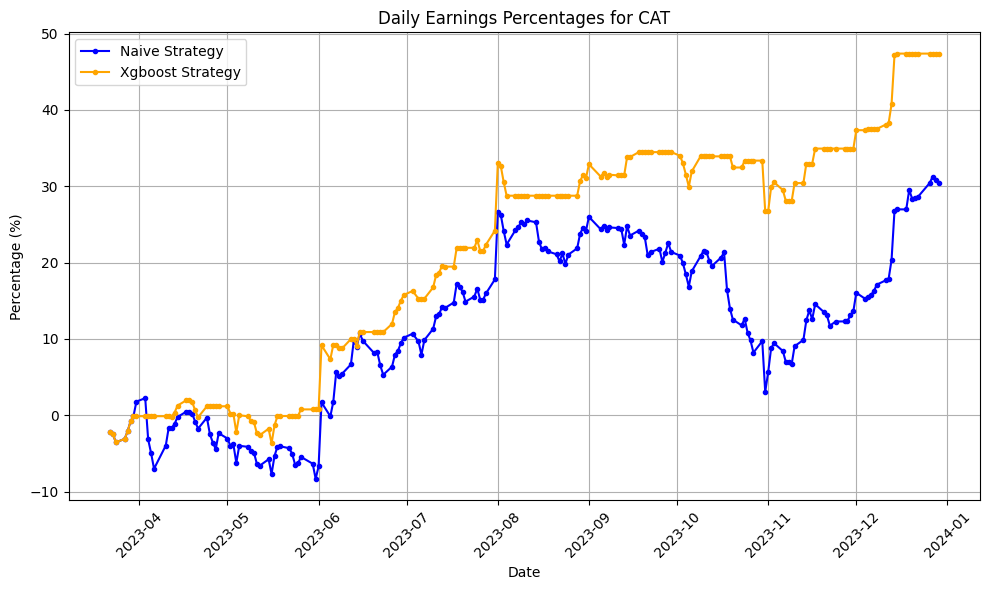

Running prediction for the stock DE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.323477              -1.892743  2.216221
1                  0.179572              -0.789932  0.969504
2                  0.321210              -1.365320  1.686530
3                  0.344952               1.684349 -1.339398
4                  0.272403               0.595404 -0.323001
..                      ...                    ...       ...
191                0.493362               0.884734 -0.391371
192                0.248341               1.121411 -0.873070
193               -0.953628               0.092214 -1.045842
194               -0.701268              -0.592572 -0.108696
195               -1.225824               0.152779 -1.378603

[196 rows x 3 columns]
Naive strategy earn rate: 1.8560826885459725 %
Xgboost strategy earn rate: 52.25010243138738 %


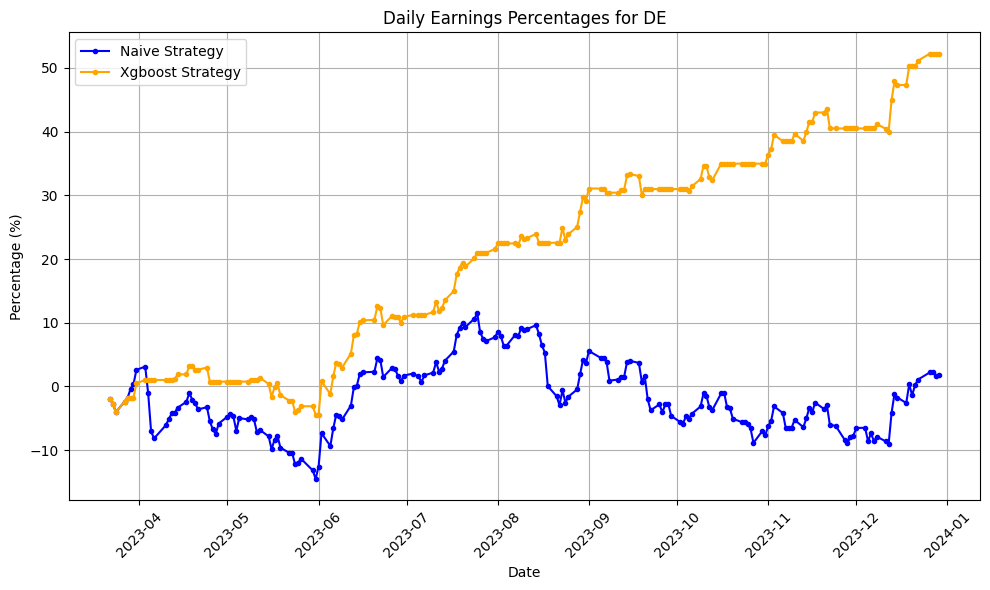

Running prediction for the stock MMM...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.078988              -2.636879  2.557890
1                 -0.189051              -0.531813  0.342762
2                 -0.500024               0.138615 -0.638639
3                 -0.411853               0.346053 -0.757906
4                 -0.506019               0.246330 -0.752348
..                      ...                    ...       ...
191                1.872901               0.729436  1.143465
192               -0.966755               1.674036 -2.640791
193                1.075188               0.582740  0.492447
194               -1.309098               0.873649 -2.182747
195               -1.325149              -0.337322 -0.987827

[196 rows x 3 columns]
Naive strategy earn rate: 7.470250360950798 %
Xgboost strategy earn rate: 17.276341086412977 %


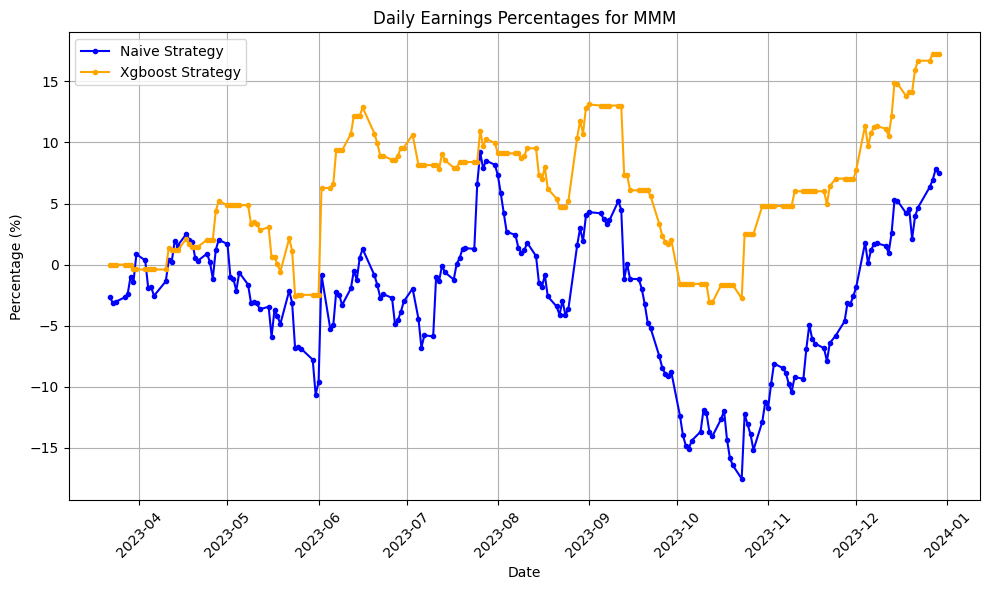

Running prediction for the stock GE...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                 -0.002591              -2.809721  2.807130
1                  0.488110               2.232391 -1.744282
2                  0.677394              -0.240196  0.917591
3                  1.035818               2.123238 -1.087420
4                  1.035476              -0.182197  1.217674
..                      ...                    ...       ...
191               -0.332813              -0.220526 -0.112288
192               -0.366509               0.615675 -0.982185
193                0.013061               0.572685 -0.559624
194               -0.220251               0.093605 -0.313857
195                0.217047              -0.537722  0.754769

[196 rows x 3 columns]
Naive strategy earn rate: 34.53245093902593 %
Xgboost strategy earn rate: 55.19516400985004 %


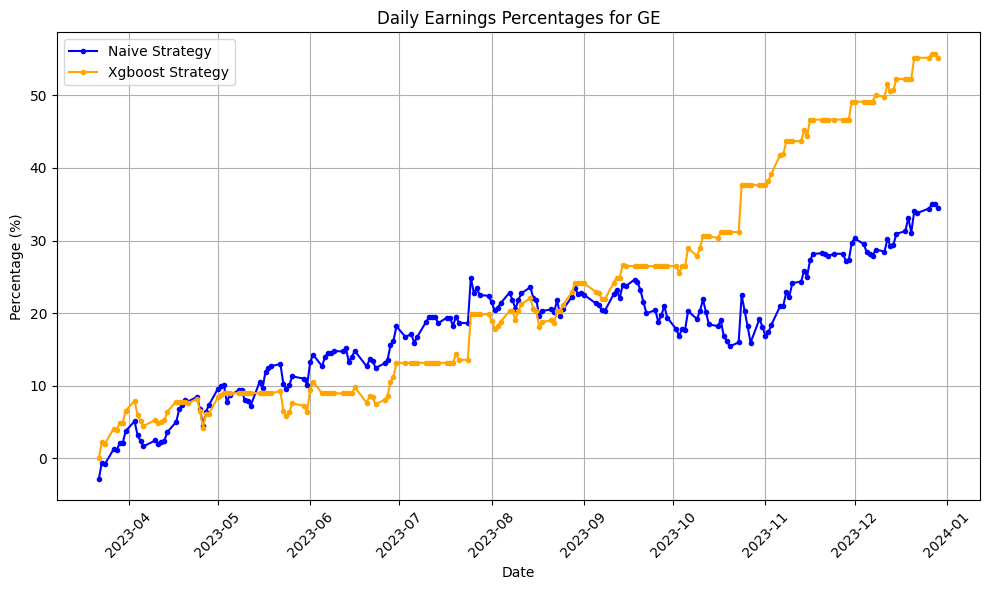

Running prediction for the stock HON...
     predict_percentages(%)  actual_percentages(%)  delta(%)
0                  0.056376              -2.092488  2.148864
1                 -0.026732              -0.128235  0.101504
2                  0.125679               0.663388 -0.537709
3                  0.146836              -0.090348  0.237183
4                  0.178721              -0.037240  0.215961
..                      ...                    ...       ...
191               -0.131986               0.287733 -0.419719
192                0.894968               1.167085 -0.272117
193                1.289355               0.471069  0.818286
194                0.002072               0.071761 -0.069688
195                0.674175               0.258167  0.416008

[196 rows x 3 columns]
Naive strategy earn rate: 10.405610200547644 %
Xgboost strategy earn rate: 29.786112166443615 %


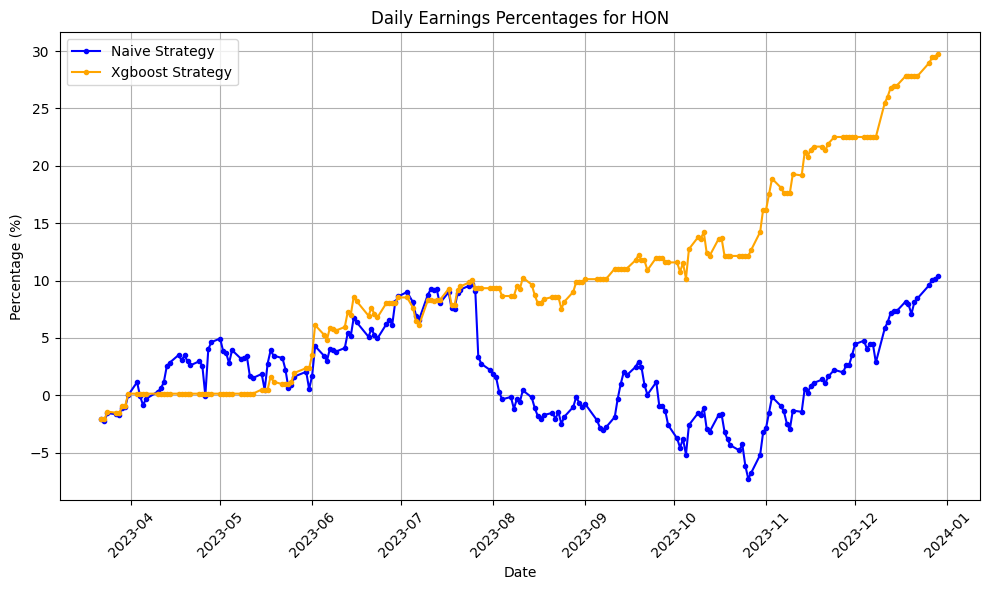

{'AAPL': {'2023-03-22 00:00:00': 0.001857624389231205,
  '2023-03-23 00:00:00': 0.002216879976913333,
  '2023-03-24 00:00:00': 0.0037994824815541506,
  '2023-03-27 00:00:00': 0.00548330694437027,
  '2023-03-28 00:00:00': 0.005082382820546627,
  '2023-03-29 00:00:00': 0.002890132600441575,
  '2023-03-30 00:00:00': 0.0027357495855540037,
  '2023-03-31 00:00:00': 0.001856350339949131,
  '2023-04-03 00:00:00': 0.004920115228742361,
  '2023-04-04 00:00:00': 0.006897427141666412,
  '2023-04-05 00:00:00': 0.0045617022551596165,
  '2023-04-06 00:00:00': 0.006824536714702845,
  '2023-04-10 00:00:00': 0.006388987880200148,
  '2023-04-11 00:00:00': 0.00297173741273582,
  '2023-04-12 00:00:00': 0.001666789292357862,
  '2023-04-13 00:00:00': 0.003139043226838112,
  '2023-04-14 00:00:00': 0.005712530110031366,
  '2023-04-17 00:00:00': 0.005707376636564732,
  '2023-04-18 00:00:00': 0.010824133642017841,
  '2023-04-19 00:00:00': 0.010333984158933163,
  '2023-04-20 00:00:00': 0.0062820506282150745,
  '

In [12]:
def predict_and_plot(ticker, data, X, y, best_params):
    print(f"Running prediction for the stock {ticker}...")
    predictions = []
    test_indices = []
    predict_percentages = []
    actual_percentages = []
    num_boost_round = best_params.pop('n_estimators')
    params = best_params

    start = int((len(data) - 1) * 0.8)
    end = (len(data) - 2)
    tune_length = int((len(data) - 1) * 0.05)

    evals_result = {}

    for i in range(start, end):
        # 第一轮使用80%数据训练
        if i == start:
            X_train = X.iloc[:i+1]
            y_train = y.iloc[:i+1]
            dtrain = xgb.DMatrix(X_train, label=y_train)
            model = xgb.train(params, dtrain, num_boost_round)
        # 之后每一轮使用5%数据微调
        else:
            X_train_new = X.iloc[i+1-tune_length:i+1]
            y_train_new = y.iloc[i+1-tune_length:i+1]
            dnew = xgb.DMatrix(X_train_new, label=y_train_new)
            model = xgb.train(params, dnew, num_boost_round, xgb_model=model)
            
        # print(f"Epoch {i-start+1}, Train Loss: {evals_result['train']['rmse'][-1]}")

        # 对后面一天的数据进行预测
        X_test = X.iloc[i+1:i+2]
        y_test = y.iloc[i+1:i+2]
        dtest = xgb.DMatrix(X_test)
        predicted_values = model.predict(dtest)

        predictions.append((1+predicted_values[0])*X['Close'].iloc[i])
        test_indices.append(y_test.index[0])

        predict_percentages.append(predicted_values[0]*100)
        actual_percentages.append(y.iloc[i+1]*100)

    delta = [p - a for p, a in zip(predict_percentages, actual_percentages)]
    result = pd.DataFrame({
        'predict_percentages(%)': predict_percentages,
        'actual_percentages(%)': actual_percentages,
        'delta(%)': delta
    })
    print(result)

    # 简单策略的收益率
    print("Naive strategy earn rate:", sum(actual_percentages), "%")

    # xgboost策略的收益率
    xgb_strategy_earn = []
    for i, predict in enumerate(predict_percentages):
        if predict > 0:
            xgb_strategy_earn.append(actual_percentages[i])
        else:
            xgb_strategy_earn.append(0)
    print("Xgboost strategy earn rate:", sum(xgb_strategy_earn), "%")

    # 绘制累积收益率曲线
    cumulative_naive_percentage = np.cumsum(actual_percentages)
    cumulative_xgb_percentage = np.cumsum(xgb_strategy_earn)
    plt.figure(figsize=(10, 6))
    plt.plot(test_indices, cumulative_naive_percentage, marker='o', markersize=3, linestyle='-', color='blue', label='Naive Strategy')
    plt.plot(test_indices, cumulative_xgb_percentage, marker='o', markersize=3, linestyle='-', color='orange', label='Xgboost Strategy')
    plt.title(f'Daily Earnings Percentages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if not os.path.exists('pic'):
        os.makedirs('pic')
    plt.savefig(f'pic/XGBoost/{ticker}.png')
    
    plt.show()

    predict_result = {str(date): pred/100 for date, pred in zip(test_indices, predict_percentages)}
    return predict_result

# 对所有股票进行预测和绘图
# best_params = {'TSLA': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 4,
#   'n_estimators': 200,
#   'subsample': 0.8},
#  'AAPL': {'colsample_bytree': 0.9,
#   'learning_rate': 0.05,
#   'max_depth': 6,
#   'n_estimators': 200,
#   'subsample': 0.6}}
all_predictions = {}
for ticker in tickers:
    data = stock_data[ticker]
    X, y = stock_features_selected[ticker]
    params = best_params[ticker]
    predict_result = predict_and_plot(ticker, data, X, y, params)
    all_predictions[ticker] =  predict_result
all_predictions

# 使用xgboost的预测结果设计策略

In [13]:
start = (int((len(data) - 1) * 0.8)+1)
start_test_date = y.iloc[start:start+1].index[0]
end = (len(data) - 2)
end_test_date = y.iloc[end:end+1].index[0]
# start_test_date = start_test_date.to_pydatetime()
# end_test_date = end_test_date.to_pydatetime()
print(end_test_date)

2023-12-29 00:00:00


In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

class MyStrategy:
    def __init__(self, symbols, start_date, end_date, model_predict={}):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.model_predict = model_predict
        self.trade_log = []
        self.Initialize()

    def Initialize(self):
        self.cash = 100000
        self.risk_free_rate = 0
        self.rebalance_time = 1
        self.last_rebalance = self.start_date
        self.portfolio = {}
        self.prev_price = {}
        self.data = self.download_data()
        
    def download_data(self):
        symbols = self.symbols + ['SPY'] # download the benchmark data
        data = yf.download(symbols, start=self.start_date, end=self.end_date+timedelta(days=5))['Adj Close']
        return data

    def calculate_sharpe_ratio(self, returns):
        excess_returns = returns - self.risk_free_rate / 252
        std = excess_returns.std()
        return np.sqrt(252) * (excess_returns.mean() / std) if std != 0 else 0

    def calculate_beta(self, stock_returns, benchmark_returns):
        assert len(stock_returns) == len(benchmark_returns)
        covariance_matrix = np.cov(stock_returns, benchmark_returns)
        return covariance_matrix[0, 1] / np.var(benchmark_returns)

    def is_bull_market(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        return recent_market_returns.mean() > 0

    def adjust_position(self, current_date):
        recent_market_data = self.data['SPY'][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=3))]
        recent_market_returns = recent_market_data.pct_change().dropna()
        market_mean_return = recent_market_returns.mean()
        if math.isnan(market_mean_return):
            return 1.0
        elif market_mean_return > 0:
            return 1.0
        elif market_mean_return > -0.02:
            return 0.8
        else:
            # print(market_mean_return)
            return max(0.8 - (market_mean_return+0.02)*10, 0)

    def rebalance(self, current_date):
        pass

    def run_backtest(self):
        # rebalance_dates = pd.date_range(self.start_date, self.end_date, freq=f'{self.rebalance_time}D')
        trading_days = self.data.index
        rebalance_dates = trading_days[::self.rebalance_time]
        portfolio_values = []
        # print(rebalance_dates)
        for date in self.data.index:
            if date in rebalance_dates and date != rebalance_dates[-1]:
                # print("before:", self.portfolio)
                # print(date)
                self.rebalance(date)
                # print("after:", self.portfolio)
            # print("cash:", self.cash)
            # print("date:", date)
            portfolio_value = self.cash + sum(self.data[symbol][date] * shares for symbol, shares in self.portfolio.items())
            # print(portfolio_value)
            portfolio_values.append(portfolio_value)
        
        return portfolio_values

    def plot_portfolio_value(self):
        portfolio_values = self.run_backtest()
        portfolio_series = pd.Series(portfolio_values, index=self.data.index)
        portfolio_series.plot(title="Portfolio Value Over Time", figsize=(10, 6))
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.grid(True)
        plt.show()

        print("Initial funding:", 100000)
        print("Final funding:", portfolio_series.iloc[-1])
        print("Yield rate:", (portfolio_series.iloc[-1] - 100000) / 100000 * 100, "%")



[*********************100%%**********************]  31 of 31 completed


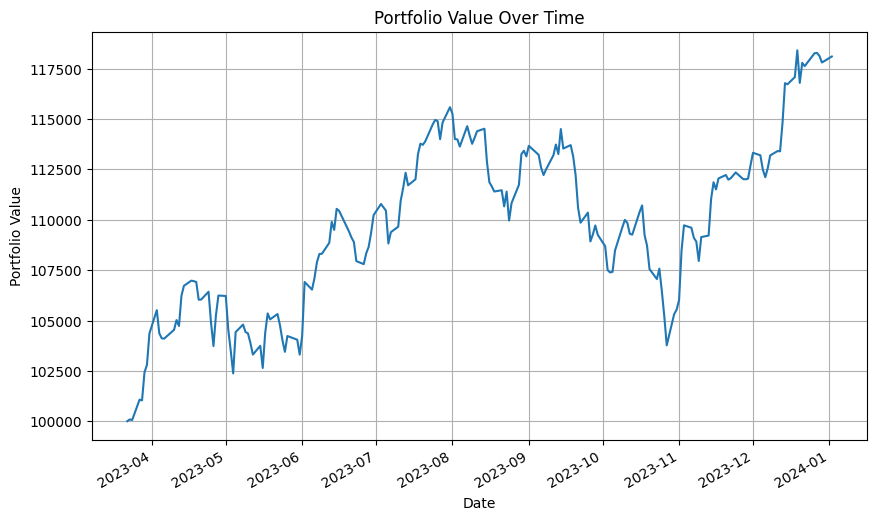

Initial funding: 100000
Final funding: 118103.13306236267
Yield rate: 18.10313306236267 %


In [16]:
class NaiveStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date):
        super().__init__(symbols, start_date, end_date)
        
    def rebalance(self, current_date):
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        self.portfolio = {}
        
        selected_symbols = self.symbols
        
        # buy the selected stocks using all the cash
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            self.portfolio[symbol] = math.floor((self.cash / num_stocks) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

naive_strategy = NaiveStrategy(symbols=tickers, start_date=start_test_date, end_date=end_test_date)
naive_strategy.plot_portfolio_value()

[*********************100%%**********************]  31 of 31 completed


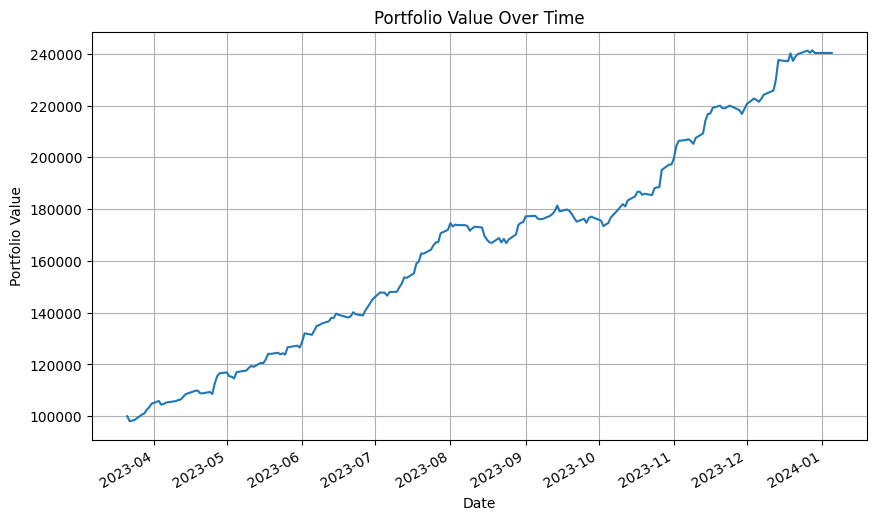

Initial funding: 100000
Final funding: 240352.72121810913
Yield rate: 140.35272121810914 %


In [17]:
 class ShortStrategy(MyStrategy):
    def __init__(self, symbols, start_date, end_date, model_predict):
        super().__init__(symbols, start_date, end_date, model_predict)
    
    def rebalance(self, current_date):

        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        self.cash += portfolio_value
        
        # Clear current portfolio
        previous_portfolio = self.portfolio.copy()
        self.portfolio = {}
        
        # calculate the sharpe ratio and the beta value of every stock
        sharpes = {}
        betas = {}
        for symbol in self.symbols:
            hist = self.data[symbol][(self.data.index <= current_date) & (self.data.index > current_date - timedelta(days=365))]
            returns = hist.pct_change().dropna()
            sharpes[symbol] = self.calculate_sharpe_ratio(returns)
            
        weights = {}
        selected_symbols = []
        current_date_index = self.data.index.get_loc(current_date)
        tomorrow = self.data.index[current_date_index + 1]
        # print("tomorrow:", tomorrow)
        for symbol, model_predict in self.model_predict.items():
            # print(model_predict)
            if (tomorrow > self.end_date):
                return 
            model_predict_tomorrow = model_predict[str(tomorrow)]
            # print("date:", current_date, "symbol:", symbol, "predict:", model_predict_tomorrow)
            if model_predict_tomorrow > 0:
                selected_symbols.append(symbol)

        for symbol in selected_symbols:
            if sharpes[symbol] < -0.5:
                selected_symbols.remove(symbol)
        
        
        # Buy the selected stocks using all the cash with stop loss
        for symbol in self.symbols:
            # Check stop loss condition using previous portfolio
            if self.prev_price:
                prev_price = self.prev_price[symbol]
                current_price = self.data[symbol][current_date]
                if (current_price - prev_price) / prev_price < -0.1: # The stop loss is set to 10%
                    if symbol in selected_symbols:
                        selected_symbols.remove(symbol) # Skip buying this stock

        # set the weights for selected symbols
        weights = {}
        for symbol, model_predict in self.model_predict.items():
            model_predict_tomorrow = model_predict[str(tomorrow)]
            if not symbol in selected_symbols:
                continue
            weights[symbol] = model_predict_tomorrow
            
        weight_sum = sum(weights.values())
        weights = {key: value / weight_sum for key, value in weights.items()}
        
        # buy the selected stocks using all the cash
        position = self.adjust_position(current_date)
        num_stocks = len(selected_symbols)
        use_cash = 0
        for symbol in selected_symbols:
            symbol_weight = weights[symbol]
            self.portfolio[symbol] = math.floor((self.cash * position * symbol_weight) / self.data[symbol][current_date])
            use_cash += self.data[symbol][current_date] * self.portfolio[symbol]
        self.cash -= use_cash

        position_change = {}
        for symbol in self.symbols:
            previous_shares = previous_portfolio.get(symbol, 0)
            current_shares = self.portfolio.get(symbol, 0)
            change = current_shares - previous_shares
            if change != 0:
                position_change[symbol] = change

        if not self.trade_log:
            earnings_per_stock = {}
        else:
            earnings_per_stock = self.trade_log[-1]['earnings_per_stock'].copy()
            # print(earnings_per_stock)
        for symbol in self.symbols:
            if symbol in previous_portfolio:
                # print(previous_portfolio, symbol)
                # print(self.prev_price)
                prev_price = self.prev_price[symbol]
                curr_price = self.data[symbol][current_date]
                hold = previous_portfolio[symbol]
                if symbol not in earnings_per_stock.keys():
                    # print(1)
                    # print(symbol)
                    earnings_per_stock[symbol] = (curr_price - prev_price) * hold
                else:
                    # print(2)
                    earnings_per_stock[symbol] += (curr_price - prev_price) * hold
        # print("after:", earnings_per_stock)

        self.prev_price = {}
                
        for symbol in self.symbols:
            self.prev_price[symbol] = self.data[symbol][current_date]
            # print(self.prev_price[symbol])

        # record the log
        portfolio_value = sum(self.data[symbol][current_date] * shares for symbol, shares in self.portfolio.items())
        if self.trade_log:
            previous_balance = self.trade_log[-1]['balance']
        else:
            previous_balance = 100000
        trade_record = {
            'date': current_date,
            'balance': portfolio_value + self.cash,
            'earning': portfolio_value + self.cash - previous_balance,
            'portfolio': self.portfolio.copy(),
            'change': position_change,
            'earnings_per_stock': earnings_per_stock,
        }
        self.trade_log.append(trade_record)
        # print(self.trade_log)
            
xgb_strategy = ShortStrategy(symbols=tickers, start_date=datetime(2023, 3, 21), end_date=datetime(2024, 1, 1), model_predict=all_predictions)
xgb_strategy.plot_portfolio_value()

In [18]:
for record in xgb_strategy.trade_log:
    print(f"Date: {record['date']}")
    print(f"Balance: {record['balance']:.2f}")
    print(f"Earning: {record['earning']:.2f}")
    print("Portfolio:")
    for symbol, shares in record['portfolio'].items():
        print(f"  {symbol}: {shares} shares")
    print("Change:")
    for symbol, shares in record['change'].items():
        print(f"  {symbol}: {shares} shares")
    print("Earnings_per_stock:")
    for symbol, earn in record['earnings_per_stock'].items():
        print(f"  {symbol}: {earn}")
    print("-" * 40)


Date: 2023-03-21 00:00:00
Balance: 100000.00
Earning: 0.00
Portfolio:
  AAPL: 20 shares
  MSFT: 5 shares
  GOOGL: 14 shares
  AMZN: 35 shares
  TSLA: 26 shares
  JPM: 3 shares
  BAC: 438 shares
  GS: 11 shares
  PFE: 1 shares
  MRK: 46 shares
  ABBV: 13 shares
  BMY: 70 shares
  XOM: 112 shares
  CVX: 8 shares
  COP: 223 shares
  BKR: 105 shares
  DIS: 10 shares
  NFLX: 1 shares
  CMCSA: 128 shares
  SBUX: 20 shares
  CAT: 27 shares
  DE: 13 shares
  HON: 5 shares
Change:
  AAPL: 20 shares
  MSFT: 5 shares
  GOOGL: 14 shares
  AMZN: 35 shares
  TSLA: 26 shares
  JPM: 3 shares
  BAC: 438 shares
  GS: 11 shares
  PFE: 1 shares
  MRK: 46 shares
  ABBV: 13 shares
  BMY: 70 shares
  XOM: 112 shares
  CVX: 8 shares
  COP: 223 shares
  BKR: 105 shares
  DIS: 10 shares
  NFLX: 1 shares
  CMCSA: 128 shares
  SBUX: 20 shares
  CAT: 27 shares
  DE: 13 shares
  HON: 5 shares
Earnings_per_stock:
----------------------------------------
Date: 2023-03-22 00:00:00
Balance: 98077.35
Earning: -1922.65
P

In [19]:
import pickle
for ticker, predictions in all_predictions.items():
  file_path = os.path.join('prediction/XGBoost', f'{ticker}_predictions.pkl')
  with open(file_path, 'wb') as file:
    pickle.dump(predictions, file)
    print(f'Saved predictions for {ticker} to {file_path}')

Saved predictions for AAPL to prediction/XGBoost\AAPL_predictions.pkl
Saved predictions for MSFT to prediction/XGBoost\MSFT_predictions.pkl
Saved predictions for GOOGL to prediction/XGBoost\GOOGL_predictions.pkl
Saved predictions for AMZN to prediction/XGBoost\AMZN_predictions.pkl
Saved predictions for TSLA to prediction/XGBoost\TSLA_predictions.pkl
Saved predictions for JPM to prediction/XGBoost\JPM_predictions.pkl
Saved predictions for BAC to prediction/XGBoost\BAC_predictions.pkl
Saved predictions for C to prediction/XGBoost\C_predictions.pkl
Saved predictions for WFC to prediction/XGBoost\WFC_predictions.pkl
Saved predictions for GS to prediction/XGBoost\GS_predictions.pkl
Saved predictions for JNJ to prediction/XGBoost\JNJ_predictions.pkl
Saved predictions for PFE to prediction/XGBoost\PFE_predictions.pkl
Saved predictions for MRK to prediction/XGBoost\MRK_predictions.pkl
Saved predictions for ABBV to prediction/XGBoost\ABBV_predictions.pkl
Saved predictions for BMY to prediction/